In [1]:
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import scipy
import json

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from tools.tools import *

sns.set_theme(style="whitegrid", palette="colorblind")
mpl.rcParams.update({
    "figure.figsize": (6.0, 4.0),
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "mathtext.default": "regular"
})


In [2]:


root = "./data"

radius = 5.5e-6 #Bead size m
rho = 1.3 * 1000 #Bead density kg/m^3
mu_0 = 4*np.pi*1e-7 #permeability
phase = 5

time_s = 80; time_e = 300
m = 3.5/(10*0.3*3.3)*1e-6

T_0 = 25
r_T_0 = 0.971e3
v = 30000e-6

# our experiments
T = 23
a = 9.2e-4
b = 4.5e-7
r_ = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
nn = v*r_

#Parameters to crop simulation
height = 1544*m #height of FoV in µm
width = 2064*m #width of FoV in µm

start_w =  0#0.0035 - width #flip
end_w = width
start_h = 0.003 - height/2; end_h = 0.003 + height/2

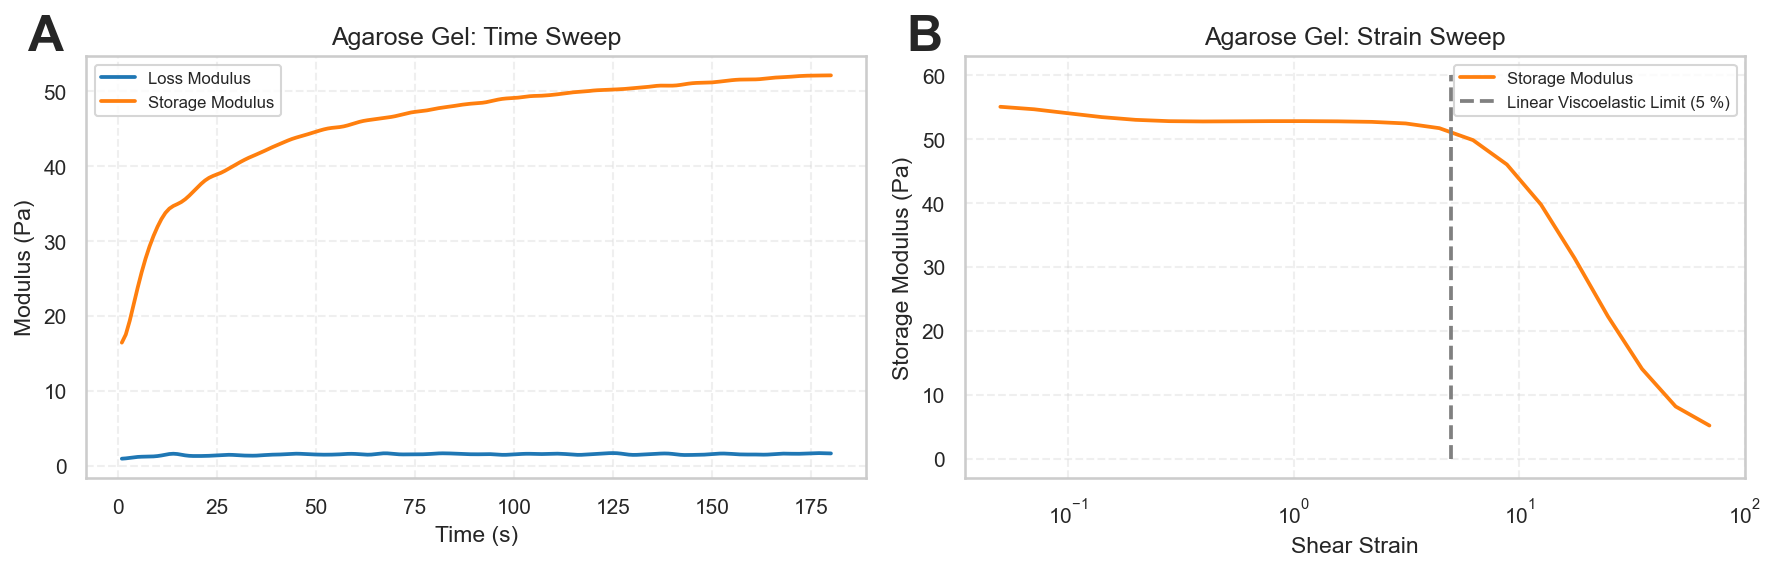

In [3]:
root = "./results/macro/Agarose_0.2_10C_20260204.xlsx"
fs = 1 # Hz

# First sheet: time sweep
sheet0 = pd.read_excel(root, skiprows=[1,2])
sheet0["time"] = sheet0["Point No."] * fs
sheet0["Loss Modulus"] = gaussian_filter(sheet0["Loss Modulus"], sigma=2)
sheet0["Storage Modulus"] = gaussian_filter(sheet0["Storage Modulus"], sigma=2)

# Second sheet: strain sweep
sheet1 = pd.read_excel(root, skiprows=[1,2], sheet_name=1)
sheet1["time"] = sheet1["Point No."] * fs
sheet1["Loss Modulus"] = gaussian_filter(sheet1["Loss Modulus"], sigma=2)
sheet1["Storage Modulus"] = gaussian_filter(sheet1["Storage Modulus"], sigma=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

sns.lineplot(x="time", y="Loss Modulus", data=sheet0, ax=axes[0], label="Loss Modulus", color="tab:blue")
sns.lineplot(x="time", y="Storage Modulus", data=sheet0, ax=axes[0], label="Storage Modulus", color="tab:orange")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Modulus (Pa)")
axes[0].set_title("Agarose Gel: Time Sweep")
axes[0].legend(frameon=True, fontsize=8)
axes[0].grid(alpha=0.3)

sns.lineplot(x="Shear Strain", y="Storage Modulus", data=sheet1, ax=axes[1], label="Storage Modulus", color="tab:orange")
axes[1].vlines(5, ymin=0, ymax=60, colors='gray', linestyles='dashed', label='Linear Viscoelastic Limit (5 %)')
axes[1].set_xscale('log')
axes[1].set_xlabel("Shear Strain")
axes[1].set_ylabel("Storage Modulus (Pa)")
axes[1].set_title("Agarose Gel: Strain Sweep")
axes[1].legend(frameon=True, fontsize=8)
axes[1].grid(alpha=0.3)

# Call the existing panel label function
add_panel_labels(axes, labels=["A", "B"], xy=(-0.075, 1.1), fontsize=24, weight="bold")

plt.tight_layout()
plt.show()

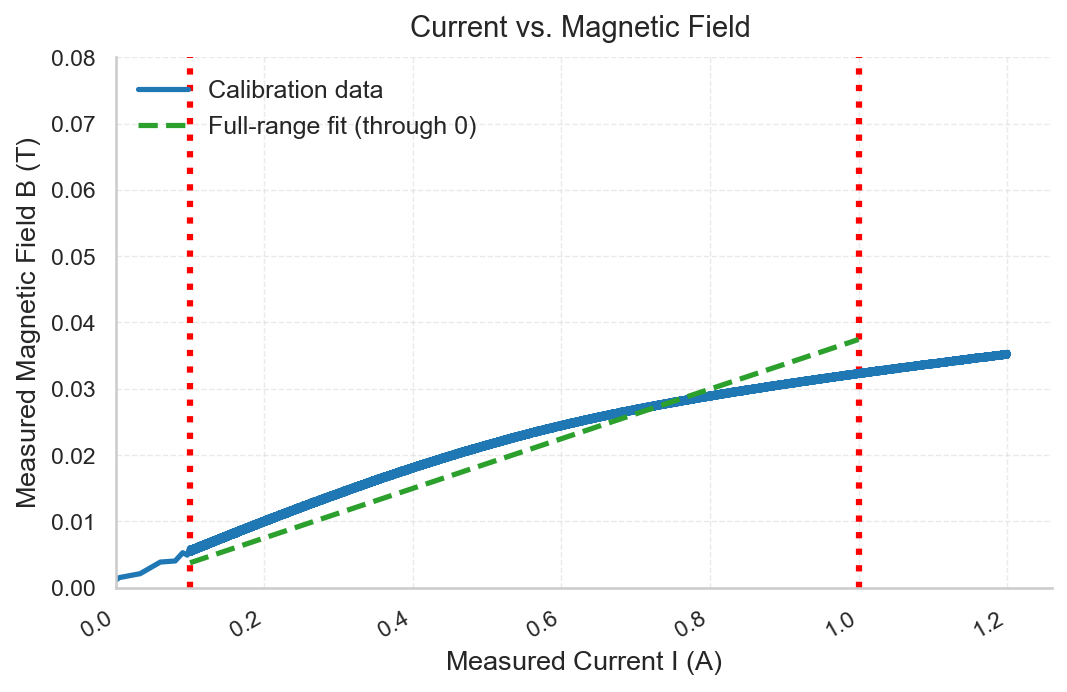

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
path = "./results/response/calibration_slope"
arr = np.load(os.path.join(path, "driver.npy")).T
data_ni = pd.DataFrame(arr, columns=["time", "i_ref", "i_meas", "b_meas", "idx", "feedback"])

# Plot all data points and the full slope line
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150, constrained_layout=True)

# Sort data for proper line connection
plot_data = data_ni.sort_values("i_meas")
    
# Plot all data points and connect them
sns.lineplot(x="i_meas", y="b_meas", data=plot_data, ax=ax, color="tab:blue", label="Calibration data", linewidth=2.5, zorder=2)

# Add vertical line at x=1
ax.axvline(x=1, ymin=0, ymax=1, color='red', linestyle=':', linewidth=3, zorder=1)
ax.axvline(x=0.1, ymin=0, ymax=1, color='red', linestyle=':', linewidth=3, zorder=1)


fit_mask = (plot_data["i_meas"] >= 0) & (plot_data["i_meas"] <= 1.0)
fit_x = plot_data.loc[fit_mask, "i_meas"]
fit_y = plot_data.loc[fit_mask, "b_meas"]

full_slope = np.sum(fit_x * fit_y) / np.sum(fit_x ** 2)
x_fit = np.linspace(0.1, fit_x.max(), 200)

ax.plot(x_fit, full_slope * x_fit, color="tab:green", linestyle="--", linewidth=2.5, label=f"Full-range fit (through 0)", zorder=3)

# Axis labels and title
ax.set_xlabel("Measured Current $I$ (A)", fontsize=13)
ax.set_ylabel("Measured Magnetic Field $B$ (T)", fontsize=13)
ax.set_title("Current vs. Magnetic Field ", fontsize=14, pad=10)

# Ticks and grid
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.7, zorder=0)
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')

# Legend and limits
ax.legend(frameon=False, fontsize=12, loc="upper left")
ax.set_ylim([0.0, 0.08])
ax.set_xlim([0.0, plot_data["i_meas"].max() * 1.05])
sns.despine()
plt.show()

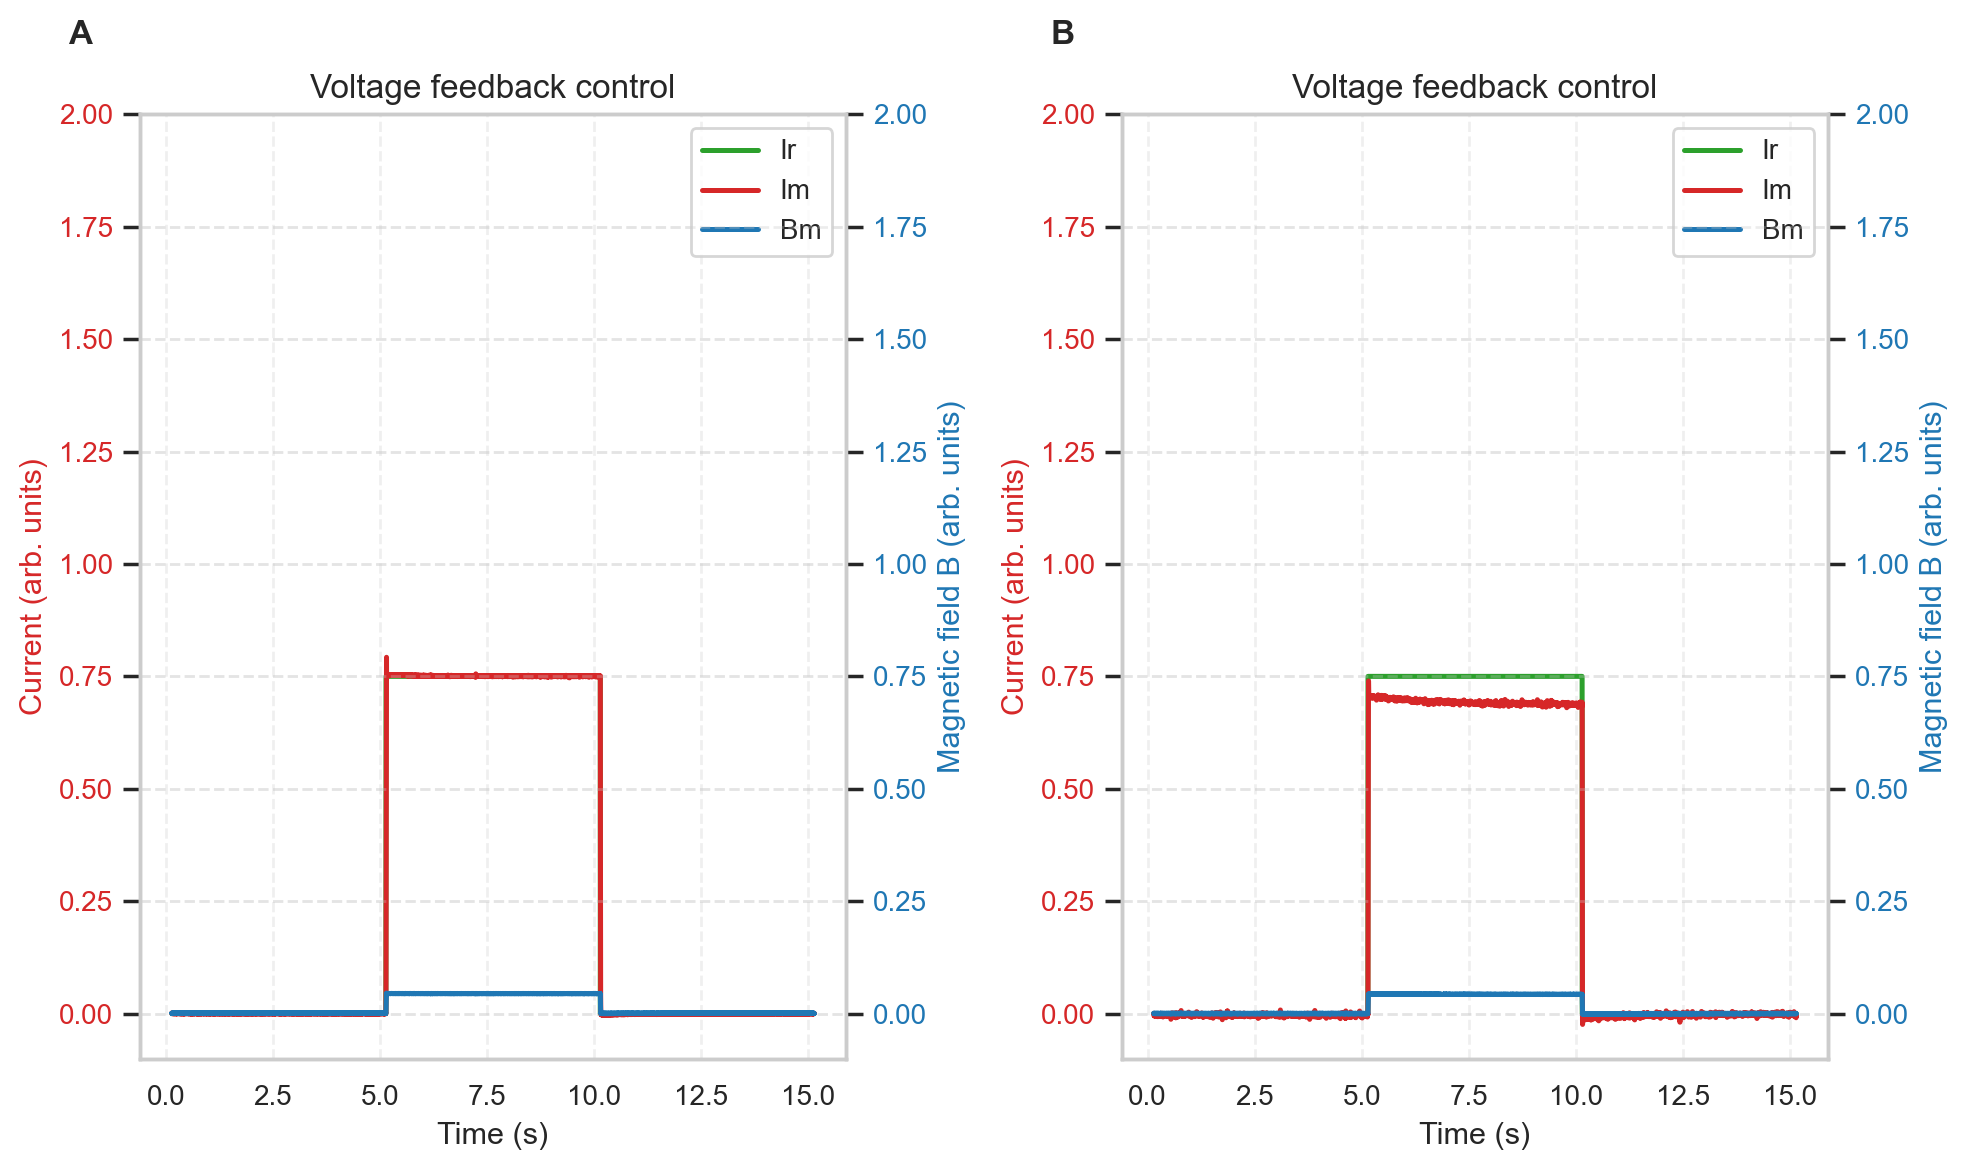

In [5]:


# %matplotlib qt
%matplotlib inline
# Currents left, Magnetic field right
fig, ax = plt.subplots(1,2, figsize=(10, 6))
paths = ["./results/response/current_response", "./results/response/Mflux_response"]
df_s = []

for path, axI in zip(paths,ax):

    arr = np.load(os.path.join(path, "driver.npy")).T

    data_ni = pd.DataFrame(arr, columns=["time", "i_ref", "i_meas", "b_meas", "idx", "feedback"])
    df_s.append(data_ni)
    
    axB = axI.twinx()

    # Left axis: currents
    i_ref_line = axI.plot(data_ni.time, data_ni.i_ref, color="tab:green", label="Ir")
    i_meas_line = axI.plot(data_ni.time, data_ni.i_meas, color="tab:red", label="Im")
    axI.set_ylabel("Current (arb. units)", color="tab:red")
    axI.tick_params(axis='y', labelcolor="tab:red")

    # Right axis: magnetic field
    b_line = axB.plot(data_ni.time, data_ni.b_meas, color="tab:blue", label="Bm")
    axB.set_ylabel("Magnetic field B (arb. units)", color="tab:blue")
    axB.tick_params(axis='y', labelcolor="tab:blue")

    # X axis
    axI.set_xlabel("Time (s)")

    # # Vertical markers
    # for tmark in (15, 30):
    #     axI.axvline(tmark, color="gray", ls="--", lw=1)

    # Combined legend
    handles = i_ref_line + i_meas_line + b_line
    labels = [h.get_label() for h in handles]
    axI.legend(handles, labels, loc="upper right")

    axI.grid(alpha=0.3)

    axI.set_ylim([-0.1,2])
    axB.set_ylim([-0.1,2])

    axI.set_title("Magnetic field control" if "magnetic_field" in path else "Voltage feedback control")
    

add_panel_labels(ax, ["A", "B"])
fig.tight_layout()
plt.show()

# fig, ax = plt.subplots(1,2, figsize=(10, 6))

# ax[0].plot(df_s[0].time, df_s[0].b_meas, label="Mg field control")
# ax[0].plot(df_s[1].time, df_s[1].b_meas, label="Voltage feedback")
# ax[0].legend()

# ax[1].plot(df_s[0].time, df_s[0].i_meas, label="Mg field control")
# ax[1].plot(df_s[1].time, df_s[1].i_meas, label="Voltage feedback")
# ax[1].legend()


# plt.show()

No tracking data found


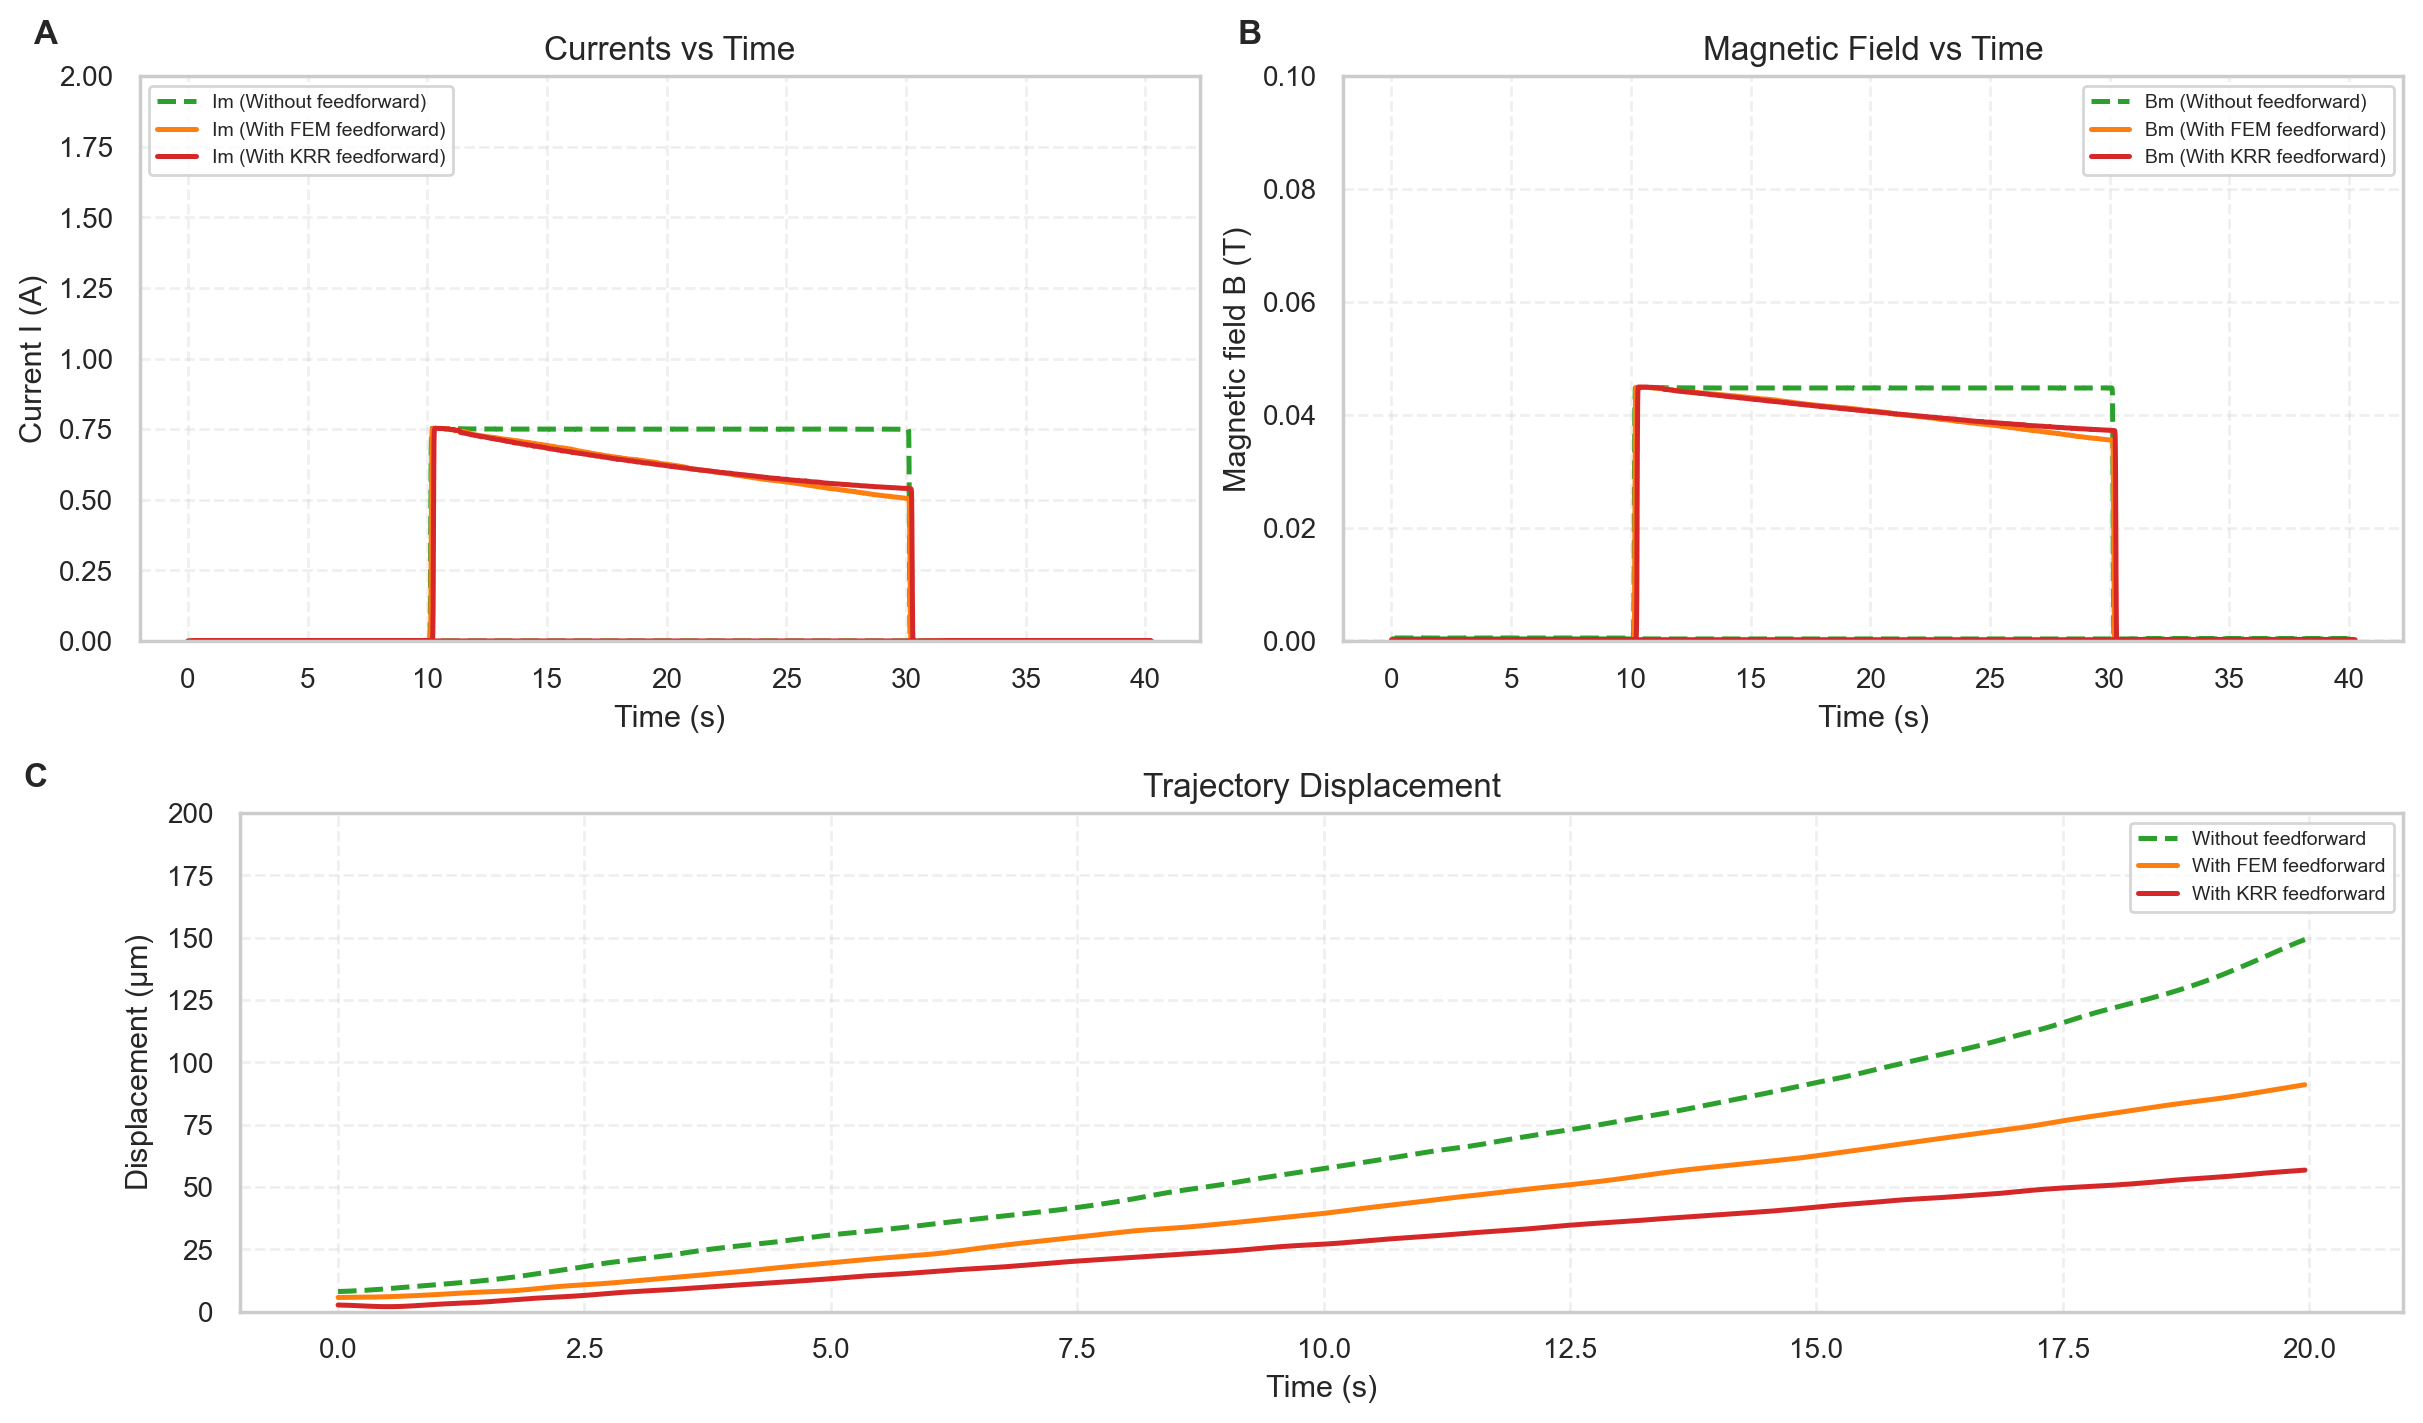

In [129]:
from scipy.ndimage import gaussian_filter1d

# Paths
path_2 = "./results/position_feedback/FEM_1_10_30"
path_1 = "./results/position_feedback/Free_1_10_30"
path_3 = "./results/position_feedback/KRR_1_10_30"


current_ylim = (-0.0001, 2.0)
b_ylim = (-0.0001, 0.1)
traj_ylim = (0, 200) 

mode_names = ["Without feedforward", "With FEM feedforward", "With KRR feedforward"]
mode_linestyles = ["--", "-", "-"]
mode_colors = ["tab:green", "tab:orange", "tab:red"]


fig = plt.figure(figsize=(12, 7), constrained_layout=True)
subfig_top, subfig_bottom = fig.subfigures(2, 1, height_ratios=[1.0, 0.9])

axs_top = subfig_top.subplots(1, 2, sharex=False)
axI = axs_top[0]
axB = axs_top[1]
axC = subfig_bottom.subplots(1, 1)

legend_handles_I = []
legend_labels_I = []
legend_handles_B = []
legend_labels_B = []

max_r = -np.inf
min_r = np.inf


for idx, path in enumerate([path_1, path_2, path_3]):

    data_ni, data_cam_t, data_track_t, data_tracker = dw_data(path)
    path_parts = os.path.split(path)[-1].split("_")


    line_meas = axI.plot(
        data_ni.time,
        gaussian_filter1d(data_ni.i_meas, sigma=15),
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx],
        label=f"Im ({mode_names[idx]})"
    )


    legend_handles_I.extend( line_meas)
    legend_labels_I.extend([h.get_label() for h in ( line_meas)])

    # Right panel (B): magnetic field
    line_B = axB.plot(
        data_ni.time,
        gaussian_filter1d(data_ni.b_meas, sigma=15),
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx],
        label=f"Bm ({mode_names[idx]})"
    )
    legend_handles_B.extend(line_B)
    legend_labels_B.extend([h.get_label() for h in line_B])

    # Interval markers from path name
    start_time = int(path_parts[-2])
    end_time = int(path_parts[-1])

    # Cross-correlation delay estimate between i_ref and i_meas near start
    lag_s = estimate_step_delay_xcorr(
        data_ni.time.values,
        data_ni.i_ref.values,
        data_ni.i_meas.values,
        t_ref=start_time,
    )

    t_start_adj = start_time + lag_s
    t_end_adj = end_time + lag_s

    idx_start_cam, idx_end_cam = map_times_to_cam_indices(
        data_cam_t.time.values,
        t_start_adj,
        t_end_adj
    )

    
    # Center-line trajectory in bottom panel (C)
    traj_t = data_tracker.t[idx_start_cam:idx_end_cam] - data_tracker.t[idx_start_cam]

    traj_r = data_tracker.r[idx_start_cam:idx_end_cam]

    axC.plot(
        traj_t,
        (traj_r*1e6),
        label=mode_names[idx],
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx]
    )
    if len(traj_r) > 0:
        max_r = max(max_r, np.max(traj_r))
        min_r = min(min_r, np.min(traj_r))


axC.legend(loc="best", frameon=True, fontsize=7)

axI.set_xlabel("Time (s)")
axI.set_ylabel("Current I (A)")
axI.tick_params(axis='y')
axI.set_ylim(current_ylim)
axI.grid(alpha=0.3)

axB.set_xlabel("Time (s)")
axB.set_ylabel("Magnetic field B (T)")
axB.tick_params(axis='y')
axB.set_ylim(b_ylim)
axB.grid(alpha=0.3)

# Legends: keep separate legends for clarity
axI.legend(legend_handles_I, legend_labels_I, loc="upper left", frameon=True, fontsize=7)
axB.legend(legend_handles_B, legend_labels_B, loc="upper right", frameon=True, fontsize=7)

# Bottom panel (C): trajectory styling
axC.set_xlabel("Time (s)")
axC.set_ylabel(r"Displacement ($\mu$m)")
axC.grid(alpha=0.3)
axC.set_ylim(traj_ylim)

# Titles and panel labels
axI.set_title("Currents vs Time")
axB.set_title("Magnetic Field vs Time")
axC.set_title("Trajectory Displacement")

try:
    add_panel_labels(axs_top, labels=["A", "B"])  # top row
    add_panel_labels([axC], labels=["C"])          # bottom row
except Exception:
    pass

plt.show()

In [130]:
import h5py

def fetch_force(y = 1, x = 1, i = 0.75):
    global m, height

    def _find_lin_bounds(ticks, v):

        n = len(ticks)
        if n < 2:
            return 0, 0, 0.0
        j = int(np.searchsorted(ticks, v))
        i0 = max(0, min(n - 2, j - 1))
        i1 = i0 + 1
        t0 = float(ticks[i0])
        t1 = float(ticks[i1])

        if t1 == t0:
            w = 0.0
        else:
            w = (float(v) - t0) / (t1 - t0)
            if w < 0.0:
                w = 0.0
            elif w > 1.0:
                w = 1.0

        return i0, i1, w

    def _trilinear(vol, x_ticks, y_ticks, i_ticks,x, y, i):

        y0, y1, wy = _find_lin_bounds(y_ticks, y)
        x0, x1, wx = _find_lin_bounds(x_ticks, x)
        i0, i1, wi = _find_lin_bounds(i_ticks, i)

        # Corner values
        V000 = float(vol[y0, x0, i0])
        V100 = float(vol[y0, x1, i0])
        V010 = float(vol[y1, x0, i0])
        V110 = float(vol[y1, x1, i0])
        V001 = float(vol[y0, x0, i1])
        V101 = float(vol[y0, x1, i1])
        V011 = float(vol[y1, x0, i1])
        V111 = float(vol[y1, x1, i1])

        # Interpolate
        c00 = V000 * (1 - wx) + V100 * wx
        c10 = V010 * (1 - wx) + V110 * wx
        c01 = V001 * (1 - wx) + V101 * wx
        c11 = V011 * (1 - wx) + V111 * wx

        c0 = c00 * (1 - wy) + c10 * wy
        c1 = c01 * (1 - wy) + c11 * wy

        val = c0 * (1 - wi) + c1 * wi
        return val

    with h5py.File("./results/force_model.h5", "r") as f:
        force_control= f["model/force_field"][...]
        x_axis = f["model/x"][...] + 1.5e-4
        y_axis = f["model/y"][...]
        i_axis = f["model/i"][...]

    y_cand = y * 1e-6 * m - height * m * 1e-6 
    x_cand = x * 1e-6 * m
    i_cand = i

    f_current = _trilinear(force_control, x_axis, y_axis, i_axis,
                                x_cand, y_cand, i_cand)
    
    return f_current


def procees_track_json_mech(temp_df, df_ref, times):
    global m, radius, nn, start_h, start_w
    
    temp_df["t"] = times["time"][:-1]
    temp_df["x_org"] = temp_df["x"].copy()
    temp_df["y_org"] = temp_df["y"].copy()
    temp_df["x"] = scipy.ndimage.gaussian_filter(temp_df["x"] - df_ref["x"],5)
    temp_df["y"] = scipy.ndimage.gaussian_filter(temp_df["y"] - df_ref["y"],5)

    temp_df["x_"] = (temp_df["x"]-temp_df["x"][0])*m
    temp_df["y_"] = (temp_df["y"]-temp_df["y"][0])*m

    temp_df["t"] = (temp_df["t"]-temp_df["t"][0])
    temp_df["y_scaled"] = temp_df["y"]*1e6*m + start_h
    temp_df["x_scaled"] = temp_df["x"]*1e6*m + start_w

    temp_df["r"] = np.sqrt(temp_df["x_"]**2 + temp_df["y_"]**2)
    temp_df["v"] = np.gradient(temp_df["r"], temp_df["t"])
    temp_df["force"] = scipy.ndimage.gaussian_filter(6*temp_df["v"].values*radius*np.pi*nn, 10)

    return temp_df

def dw_data_mech(path, id):
    def _df_from_columns(obj, cols):
        if isinstance(obj, list):
            return pd.DataFrame(obj)[cols]
        if isinstance(obj, dict):
            arrays = {c: np.asarray(obj.get(c, [])) for c in cols}
            n = min((len(a) for a in arrays.values()), default=0)
            return pd.DataFrame({c: arrays[c][:n] for c in cols})
        return pd.DataFrame()
    
    try:
        arr = np.load(os.path.join(path, "driver.npy")).T
        data_ni = pd.DataFrame(arr, columns=["time", "i_ref", "i_meas", "b_meas", "idx", "feedback"])
    except:
        print("No data_ni data found")
        data_ni = None

    try:
        arr = np.load(os.path.join(path,"timestamps.npy")).T
        data_cam_t =  pd.DataFrame(arr, columns=["time"])
    except:
        print("No data_cam_t data found")
        data_cam_t = None
    try:
        arr = np.load(os.path.join(path,"tracking_data.npy"))
        data_track_t =  pd.DataFrame(arr, columns=["x", "y", "r", "time"])
    except:
        print("No tracking data found")
        data_track_t = None
    
    # try:
    with open(os.path.join(path,"track.json"), "rb") as input_file:
        track_json = json.load(input_file)

    df_track = _df_from_columns(track_json["big_0"], ["x", "y"])
    while True:
        try:
            df_track_ref = _df_from_columns(track_json[f"ref_{id}"], ["x", "y"])
            print("using id: ", id)
            break
        except:
            id += 1
            if id == 10:
                df_track = None
                break


    df_track = procees_track_json_mech(df_track, df_track_ref, data_cam_t)

    return data_ni, data_cam_t, data_track_t, df_track

No tracking data found
using id:  0
using id:  1
using id:  2


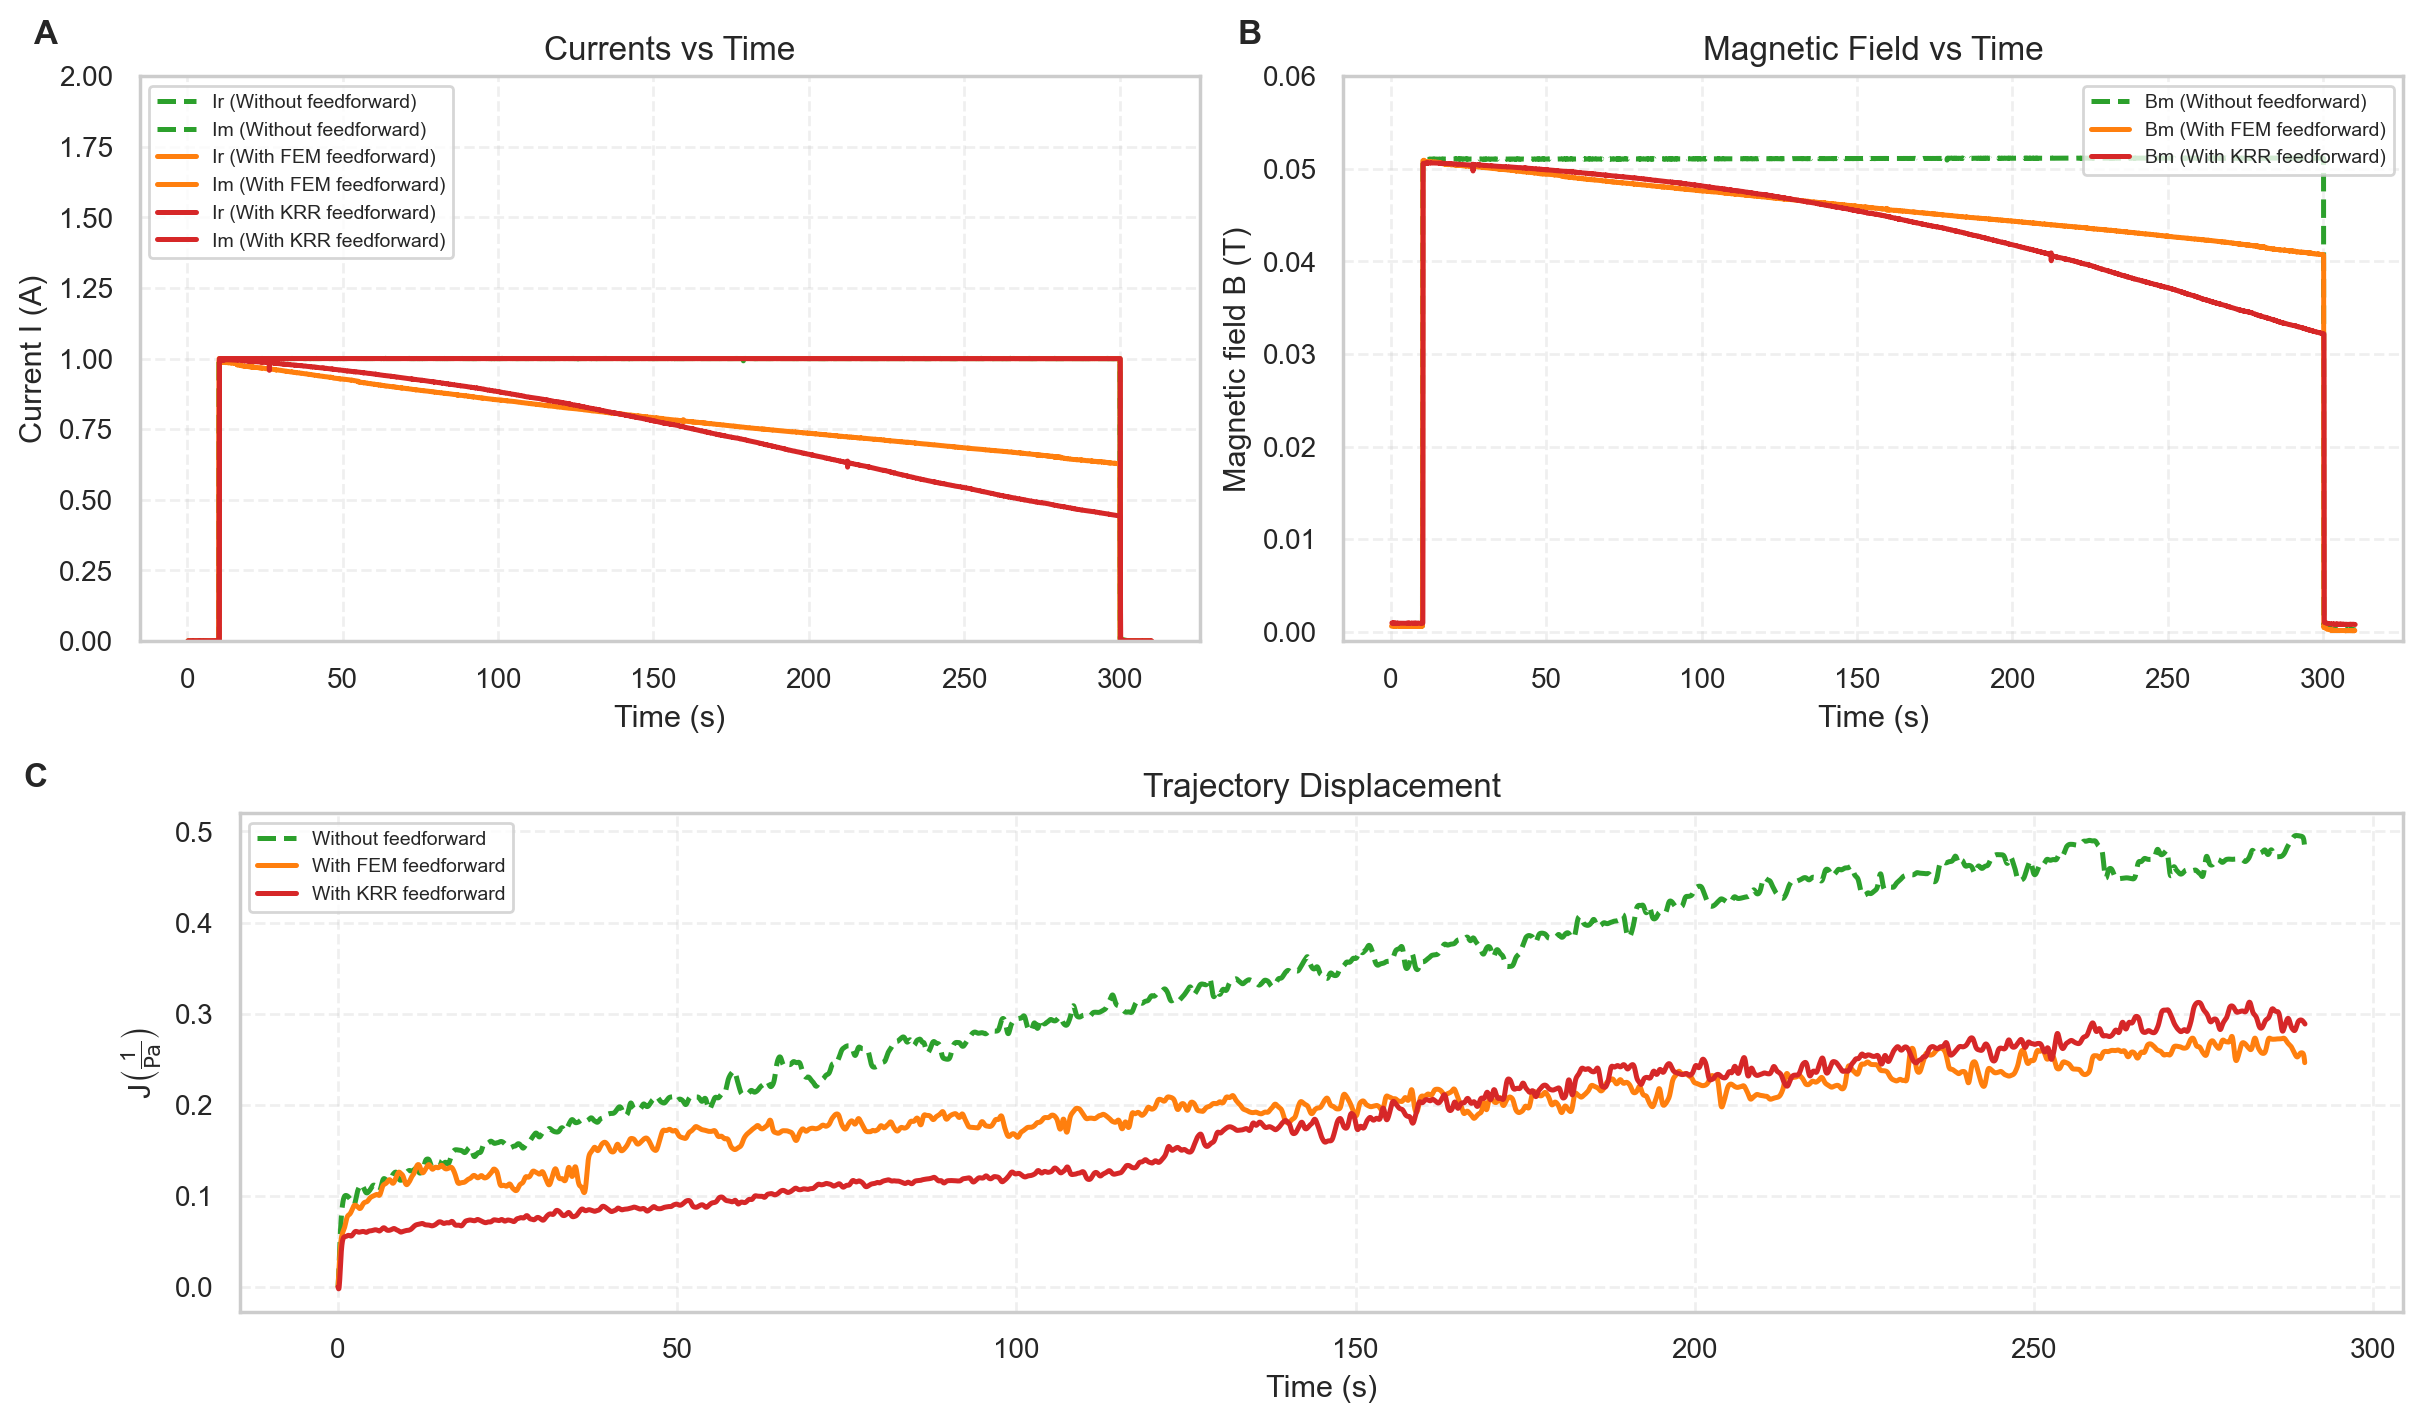

In [160]:
from scipy.ndimage import gaussian_filter1d

# Paths

path_1 = "./results/mechanics/Free_0.1_1_10_300"
path_2 = "./results/mechanics/FEM_0.1_1_10_300"
path_3 = "./results/mechanics/KRR_0.1_1_10_300"


current_ylim = (-0.0001, 2.0)
b_ylim = (-0.001, 0.06)
traj_ylim = (0, 350)  
mode_names = ["Without feedforward", "With FEM feedforward", "With KRR feedforward"]
mode_linestyles = ["--", "-", "-"]
mode_colors = ["tab:green", "tab:orange", "tab:red"]


fig = plt.figure(figsize=(12, 7), constrained_layout=True)
subfig_top, subfig_bottom = fig.subfigures(2, 1, height_ratios=[1.0, 0.9])
axs_top = subfig_top.subplots(1, 2, sharex=False)

axI = axs_top[0]
axB = axs_top[1]
axC = subfig_bottom.subplots(1, 1)

legend_handles_I = []
legend_labels_I = []
legend_handles_B = []
legend_labels_B = []

max_r = -np.inf
min_r = np.inf

ref_idx = [0, 1, 2]
vel_dict = {}

for idx, path in enumerate([path_1, path_2, path_3]):

    data_ni, data_cam_t, data_track_t, data_tracker = dw_data_mech(path, ref_idx[idx])
    path_parts = os.path.split(path)[-1].split("_")

    # Left panel (A): currents (ref + meas)
    line_ref = axI.plot(
        data_ni.time,
        gaussian_filter1d(data_ni.i_ref, sigma=15),
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx],
        label=f"Ir ({mode_names[idx]})"
    )
    line_meas = axI.plot(
        data_ni.time,
        gaussian_filter1d(data_ni.i_meas, sigma=15),
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx],
        label=f"Im ({mode_names[idx]})"
    )
    legend_handles_I.extend(line_ref + line_meas)
    legend_labels_I.extend([h.get_label() for h in (line_ref + line_meas)])

    # Right panel (B): magnetic field
    line_B = axB.plot(
        data_ni.time,
        gaussian_filter1d(data_ni.b_meas, sigma=15),
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx],
        label=f"Bm ({mode_names[idx]})"
    )
    legend_handles_B.extend(line_B)
    legend_labels_B.extend([h.get_label() for h in line_B])

    # Interval markers from path name
    start_time = int(path_parts[-2])
    end_time = int(path_parts[-1])

    # Cross-correlation delay estimate near start
    lag_s = estimate_step_delay_xcorr(
        data_ni.time.values,
        data_ni.i_ref.values,
        data_ni.i_meas.values,
        t_ref=start_time,
    )

    t_start_adj = start_time + lag_s
    t_end_adj = end_time + lag_s

    idx_start_cam, _ = map_times_to_cam_indices(
        data_cam_t.time.values,
        t_start_adj,
        None
    )

    idx_end_cam, _ = map_times_to_cam_indices(
        data_cam_t.time.values,
        t_end_adj,
        None
    )

    # Center-line trajectory in bottom panel (C)
    traj_t = data_tracker.t[idx_start_cam:idx_end_cam] - data_tracker.t[idx_start_cam]
    traj_r = data_tracker.r[idx_start_cam:idx_end_cam] - data_tracker.r[idx_start_cam]
    alpha = (6*np.pi*(radius))/fetch_force(data_tracker["x_org"].values[0], data_tracker["y_org"].values[0])

    axC.plot(
        traj_t,
        traj_r * alpha,
        label=mode_names[idx],
        color=mode_colors[idx],
        linestyle=mode_linestyles[idx]
    )

    if len(traj_r) > 0:
        max_r = max(max_r, np.max(traj_r))
        min_r = min(min_r, np.min(traj_r))


axC.legend(loc="best", frameon=True, fontsize=7)

# Axis labels and limits (A: currents, B: magnetic field)
axI.set_xlabel("Time (s)")
axI.set_ylabel("Current I (A)")
axI.tick_params(axis='y')
axI.set_ylim(current_ylim)
axI.grid(alpha=0.3)

axB.set_xlabel("Time (s)")
axB.set_ylabel("Magnetic field B (T)")
axB.tick_params(axis='y')
axB.set_ylim(b_ylim)
axB.grid(alpha=0.3)

# Legends: keep separate legends for clarity
axI.legend(legend_handles_I, legend_labels_I, loc="upper left", frameon=True, fontsize=7)
axB.legend(legend_handles_B, legend_labels_B, loc="upper right", frameon=True, fontsize=7)

# Bottom panel (C): trajectory styling
axC.set_xlabel("Time (s)")
axC.set_ylabel(r"$J \left(\frac{1}{\mathrm{Pa}}\right)$")
axC.grid(alpha=0.3)
# axC.set_ylim(traj_ylim)

# Titles and panel labels
axI.set_title("Currents vs Time")
axB.set_title("Magnetic Field vs Time")
axC.set_title("Trajectory Displacement")

try:
    add_panel_labels(axs_top, labels=["A", "B"])  # top row
    add_panel_labels([axC], labels=["C"])          # bottom row
except Exception:
    pass

plt.show()

No tracking data found
using id:  0
No tracking data found
using id:  1
No tracking data found
using id:  0
using id:  1
using id:  0
using id:  1
using id:  2


C:\Users\lehto\AppData\Local\Temp\ipykernel_23000\51955475.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=traj_df, x='time', y='strain', hue='mode', ci='sd', ax=ax[panel], linewidth=2.2, alpha=0.5, palette=palette, hue_order=mode_labels)


No tracking data found
using id:  0
No tracking data found
using id:  1
No tracking data found
using id:  2
No tracking data found
using id:  0
using id:  1
using id:  2
using id:  0
using id:  1
using id:  2


C:\Users\lehto\AppData\Local\Temp\ipykernel_23000\51955475.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=traj_df, x='time', y='strain', hue='mode', ci='sd', ax=ax[panel], linewidth=2.2, alpha=0.5, palette=palette, hue_order=mode_labels)


No tracking data found
using id:  0
No tracking data found
using id:  1
No tracking data found
using id:  2
No tracking data found
using id:  3
No tracking data found
using id:  0
using id:  1
using id:  2
using id:  3
using id:  4
using id:  0
using id:  1
using id:  2
using id:  3
using id:  4


C:\Users\lehto\AppData\Local\Temp\ipykernel_23000\51955475.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=traj_df, x='time', y='strain', hue='mode', ci='sd', ax=ax[panel], linewidth=2.2, alpha=0.5, palette=palette, hue_order=mode_labels)
C:\Users\lehto\AppData\Local\Temp\ipykernel_23000\51955475.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.22)


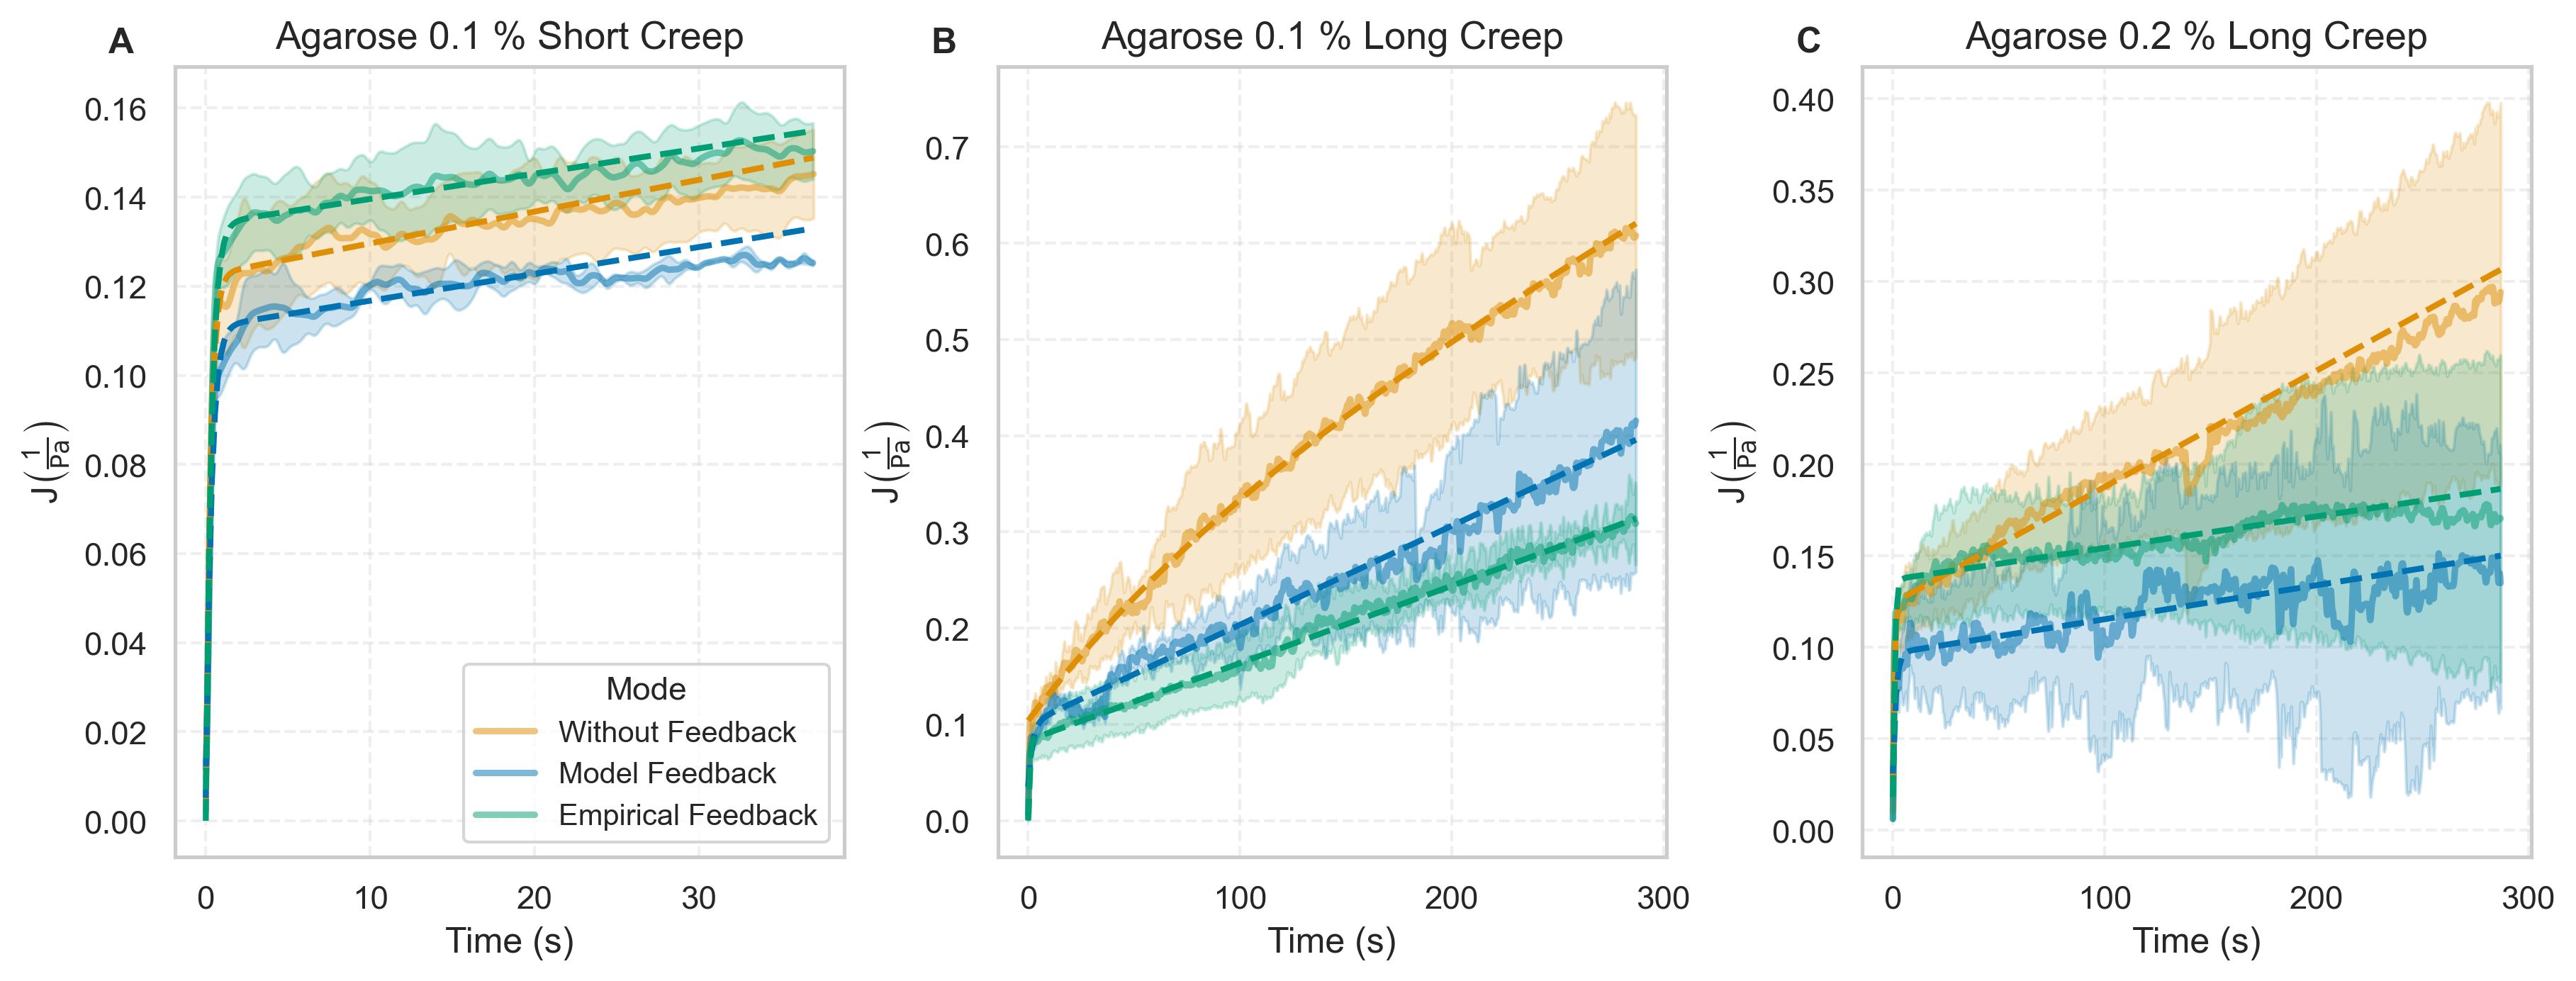

In [162]:

colorblind_palette = sns.color_palette("colorblind")
# Models
def burgers(t, E1, E2, eta1, eta2):
    return (1.0 / E1) + (t / eta1) + (1.0 / E2) * (1.0 - np.exp(- (E2 * t) / eta2))



mode_labels = ["Without Feedback", "Model Feedback", "Empirical Feedback"]

mode_color_map = {
    "Without Feedback": colorblind_palette[1],
    "Model Feedback": colorblind_palette[0],
    "Empirical Feedback": colorblind_palette[2]
}
palette = [mode_color_map[label] for label in mode_labels]

fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), dpi=300, constrained_layout=True)

paths = [
    ["./results/mechanics/Free_0.1_1_10_50", "./results/mechanics/FEM_0.1_1_10_50", "./results/mechanics/KRR_0.1_1_10_50"],
    ["./results/mechanics/Free_0.1_1_10_300", "./results/mechanics/FEM_0.1_1_10_300", "./results/mechanics/KRR_0.1_1_10_300"],
    ["./results/mechanics/Free_0.2_2_10_300", "./results/mechanics/FEM_0.2_2_10_300", "./results/mechanics/KRR_0.2_2_10_300"]
]
titles = [
    "Agarose 0.1 % Short Creep",
    "Agarose 0.1 % Long Creep",
    "Agarose 0.2 % Long Creep"
]

fit_results = []

for panel, (panel_paths, title) in enumerate(zip(paths, titles)):
    avg_signals = {}
    for idx, path in enumerate(panel_paths):
        j = 0
        avg_signals[idx] = []
        path_parts = os.path.split(path)[-1].split("_")
        while True:
            try:
                data_ni, data_cam_t, data_track_t, data_tracker = dw_data_mech(path, j)
            except Exception:
                break
            if data_tracker is None:
                break
            
            j += 1
            start_time = int(path_parts[-2])
            end_time = int(path_parts[-1])

            lag_s = estimate_step_delay_xcorr(
                data_ni.time.values,
                data_ni.i_ref.values,
                data_ni.i_meas.values,
                t_ref=start_time,
            )
            
            t_start_adj = start_time
            t_end_adj = end_time -3
            idx_start_cam, _ = map_times_to_cam_indices(
                data_cam_t.time.values, t_start_adj, None)
            idx_end_cam, _ = map_times_to_cam_indices(
                data_cam_t.time.values, t_end_adj, None)
            
            traj_t = data_tracker.t[idx_start_cam:idx_end_cam] - data_tracker.t[idx_start_cam]
            traj_r = gaussian_filter(data_tracker.r[idx_start_cam:idx_end_cam] - data_tracker.r[idx_start_cam], 2)
            alpha = (6 * np.pi * (radius)) / fetch_force(data_tracker["x_org"].values[0], data_tracker["y_org"].values[0])
            avg_signals[idx].append([traj_t, traj_r * alpha])
    # Collect all data
    rows = []
    for key, data in avg_signals.items():
        for count, (traj_t, traj_r) in enumerate(data):
            for t, r in zip(traj_t, traj_r):
                rows.append({'mode': mode_labels[key], 'time': t, 'strain': r, 'rep': count})
    if rows:
        traj_df = pd.DataFrame(rows)
        g = sns.lineplot(data=traj_df, x='time', y='strain', hue='mode', ci='sd', ax=ax[panel], linewidth=2.2, alpha=0.5, palette=palette, hue_order=mode_labels)
        handles, _ = ax[panel].get_legend_handles_labels()
        for mode in mode_labels:
            data = traj_df[traj_df['mode'] == mode].dropna(subset=["time", "strain"]).reset_index(drop=True)
            x_val = data["time"].values
            y_val = data["strain"].values
            sort_idx = np.argsort(x_val)
            x_val = x_val[sort_idx]
            y_val = y_val[sort_idx]
            t_max = np.max(x_val) if len(x_val) else 1.0
            sigma = 1.0 + 10.0 * (x_val / max(t_max, 1e-9)) ** 2
            try:
                p_burgers, _ = curve_fit(
                    burgers, x_val, y_val,
                    method='dogbox',
                    bounds=([1e-12, 1e-12, 1e-12, 1e-12], [np.inf, np.inf, np.inf, np.inf]),
                    sigma=sigma,
                    absolute_sigma=False,
                    maxfev=200000
                )
                x_fit = np.linspace(x_val.min(), x_val.max(), num=200)
                y_burgers = burgers(x_fit, *p_burgers)
                ax[panel].plot(x_fit, y_burgers, color=mode_color_map[mode], linestyle='--', linewidth=2)
                fit_results.append({
                    'panel': panel,
                    'mode': mode,
                    'E1': p_burgers[0],
                    'E2': p_burgers[1],
                    'eta1': p_burgers[2],
                    'eta2': p_burgers[3]
                })
            except Exception:
                pass
        ax[panel].set_xlabel('Time (s)', fontsize=12)
        ax[panel].set_ylabel(r"$J \left(\frac{1}{\mathrm{Pa}}\right)$", fontsize=12)
        ax[panel].set_title(titles[panel], fontsize=13)
        ax[panel].grid(alpha=0.3)
        ax[panel].tick_params(axis='both', which='major', labelsize=11)
        if panel == 0:
            line_handles = handles[:3]
            ax[panel].legend(line_handles, mode_labels, title='Mode', frameon=True, fontsize=10, title_fontsize=11)
        else:
            ax[panel].get_legend().remove()
    else:
        ax[panel].set_title(titles[panel] + " (no data)", fontsize=13)
        ax[panel].axis('off')

plt.subplots_adjust(wspace=0.22)
add_panel_labels(ax, labels=["A", "B", "C"], xy=(-0.1, 1.05))  # top row

plt.show()



In [133]:
latex_rows = []
panel_titles = titles
mode_labels = ["Without Feedback", "Model Feedback", "Empirical Feedback"]
for panel in range(3):
    for mode in mode_labels:
        # Find fit result for this panel and mode
        fit = next((f for f in fit_results if f['panel'] == panel and f['mode'] == mode), None)
        if fit:
            latex_rows.append(f"{panel_titles[panel]} & {mode} & {fit['E1']:.3g} & {fit['E2']:.3g} & {fit['eta1']:.3g} & {fit['eta2']:.3g} \\\\")
        else:
            latex_rows.append(f"{panel_titles[panel]} & {mode} & - & - & - & - \\\\")
latex_table = """
\\begin{tabular}{llcccc}
Panel & Mode & $E_1$ & $E_2$ & $\\eta_1$ & $\\eta_2$ \\\\
\\hline
""" + "\n".join(latex_rows) + "\n\\end{tabular}"

print(latex_table)


\begin{tabular}{llcccc}
Panel & Mode & $E_1$ & $E_2$ & $\eta_1$ & $\eta_2$ \\
\hline
Agarose 0.1 % Short Creep & Without Feedback & 542 & 8.29 & 1.4e+03 & 2.38 \\
Agarose 0.1 % Short Creep & Model Feedback & 194 & 9.47 & 1.66e+03 & 3.15 \\
Agarose 0.1 % Short Creep & Empirical Feedback & 7.07e+08 & 7.47 & 1.76e+03 & 2.48 \\
Agarose 0.1 % Long Creep & Without Feedback & 9.64 & 6.46 & 777 & 613 \\
Agarose 0.1 % Long Creep & Model Feedback & 28.5 & 15.3 & 972 & 30.2 \\
Agarose 0.1 % Long Creep & Empirical Feedback & 1.12e+09 & 12 & 1.25e+03 & 6.49 \\
Agarose 0.2 % Long Creep & Without Feedback & 37.6 & 10.2 & 1.57e+03 & 7.35 \\
Agarose 0.2 % Long Creep & Model Feedback & 32.2 & 15.2 & 5.38e+03 & 21.1 \\
Agarose 0.2 % Long Creep & Empirical Feedback & 55.1 & 8.41 & 5.79e+03 & 6.96 \\
\end{tabular}


Text(0, 0.5, 'Force (N)')

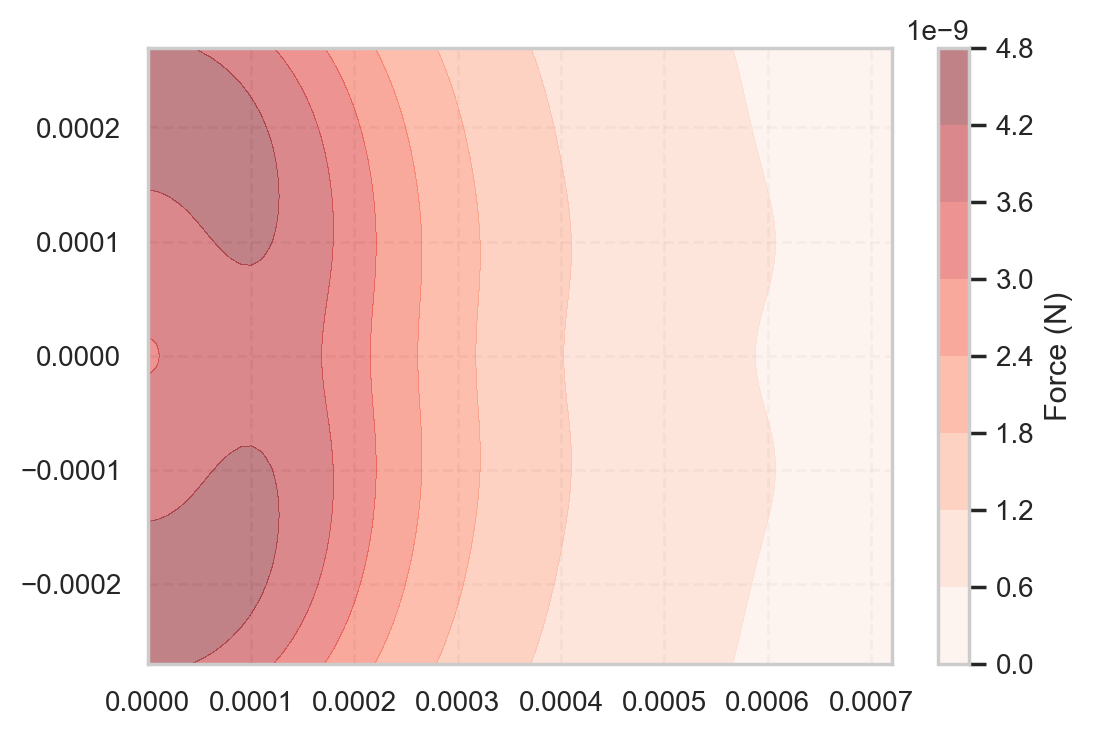

In [142]:
# Load
level = 5

mm_fit = pd.read_csv("./results/mg_calib_slopes.csv")

with h5py.File("./results/force_model.h5", "r") as f:
    force_control= f["model/force_field"][...]
    f2i = f["model/F2I"][...]
    x_axis = f["model/x"][...]
    y_axis = f["model/y"][...]
    i_axis = f["model/i"][...]

fig, ax = plt.subplots(1,1)

CS = ax.contourf(x_axis, y_axis, force_control[:,:,level], alpha = 0.5, cmap = "Reds")
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Force (N)')
cbar.ax.set_ylabel('Force (N)')

In [143]:
# Heat maps via saved model bundles (KRR & GPR)

import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_model_bundle(path):
    bundle = joblib.load(path)
    return bundle

def predict_grid(bundle, xg, yg, ig):
    XX, YY, II = np.meshgrid(xg, yg, ig, indexing='xy')
    Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)
    Xs = bundle['sx'].transform(Xgrid)
    y_scaled = bundle['model'].predict(Xs)
    Y = bundle['sy'].inverse_transform(np.asarray(y_scaled).reshape(-1, 1)).ravel()
    
    return Y.reshape(len(yg), len(xg), len(ig))


def predict_grid_std(bundle, xg, yg, ig):
    XX, YY, II = np.meshgrid(xg, yg, ig, indexing='xy')
    Xgrid = np.stack([XX.ravel(), YY.ravel(), II.ravel()], axis=1)
    Xs = bundle['sx'].transform(Xgrid)
    model = bundle['model']
    mu_s, std_s = model.predict(Xs, return_std=True)

    mu_s = np.asarray(mu_s).ravel()
    std_s = np.asarray(std_s).ravel()
    sy = bundle['sy']
    # Map std back to original target units via inverse-transform delta
    y0 = sy.inverse_transform(mu_s.reshape(-1, 1)).ravel()
    y1 = sy.inverse_transform((mu_s + std_s).reshape(-1, 1)).ravel()
    std = (y1 - y0)
    return std.reshape(len(yg), len(xg), len(ig))

krr_bundle = load_model_bundle('./results/force_krr_mg_v2.joblib')
gpr_bundle = load_model_bundle('./results/force_gpr.joblib')

krr_bundle_ref = load_model_bundle('./results/force_krr_ref_v2.joblib')
gpr_bundle_ref = load_model_bundle('./results/force_gpr_ref.joblib')



xg = x_axis
yg = y_axis
ig = i_axis

# Predict means
krr_pred = predict_grid(krr_bundle, xg, yg, ig)
gpr_pred = predict_grid(gpr_bundle, xg, yg, ig)
gpr_pred_ref = predict_grid(gpr_bundle_ref, xg, yg, ig)
krr_pred_ref = predict_grid(krr_bundle_ref, xg, yg, ig)

krr_diff = krr_pred - krr_pred_ref
gpr_diff = gpr_pred - gpr_pred_ref

# Predict std (GPR only)
gpr_std = predict_grid_std(gpr_bundle, xg, yg, ig)

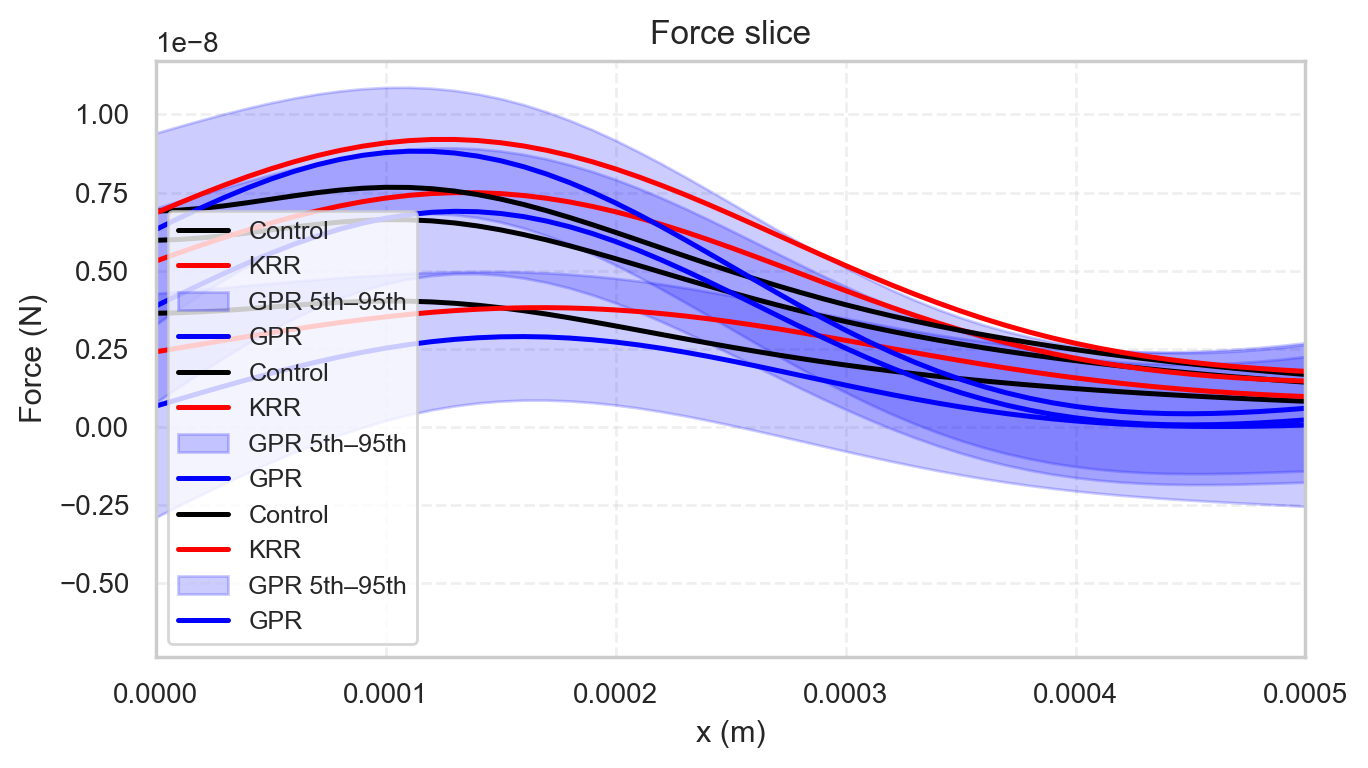

In [144]:
level = 12
fig, ax = plt.subplots(figsize=(7,4))

for level in [5, 10, 12]:
    # Control slice
    ctrl_line = force_control[30, :, level]
    ax.plot(x_axis, ctrl_line, label="Control", color="black")

    ax.plot(xg - 1e-4, krr_diff[30,:,level], label="KRR", color="red")

    #https://gaussianprocess.org/gpml/chapters/RW.pdf
    # Combine independent uncertainties from two GPR models
    gpr_std_diff = (gpr_std[30,:,level])

    z = 1.645
    lower = gpr_diff[30,:, level] - z * gpr_std_diff
    upper = gpr_diff[30,:, level] + z * gpr_std_diff

    # Shaded uncertainty band
    ax.fill_between(xg - 1e-4, lower, upper, color='blue', alpha=0.20, label='GPR 5th–95th')
    # Mean difference line
    ax.plot(xg - 1e-4, gpr_diff[30,:, level], label="GPR", color="blue")

ax.set_xlabel("x (m)")
ax.set_ylabel("Force (N)")
ax.set_title("Force slice")
ax.legend(frameon=True, fontsize=9)
ax.grid(alpha=0.3)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlim([0, 5e-4])
plt.tight_layout()
plt.show()

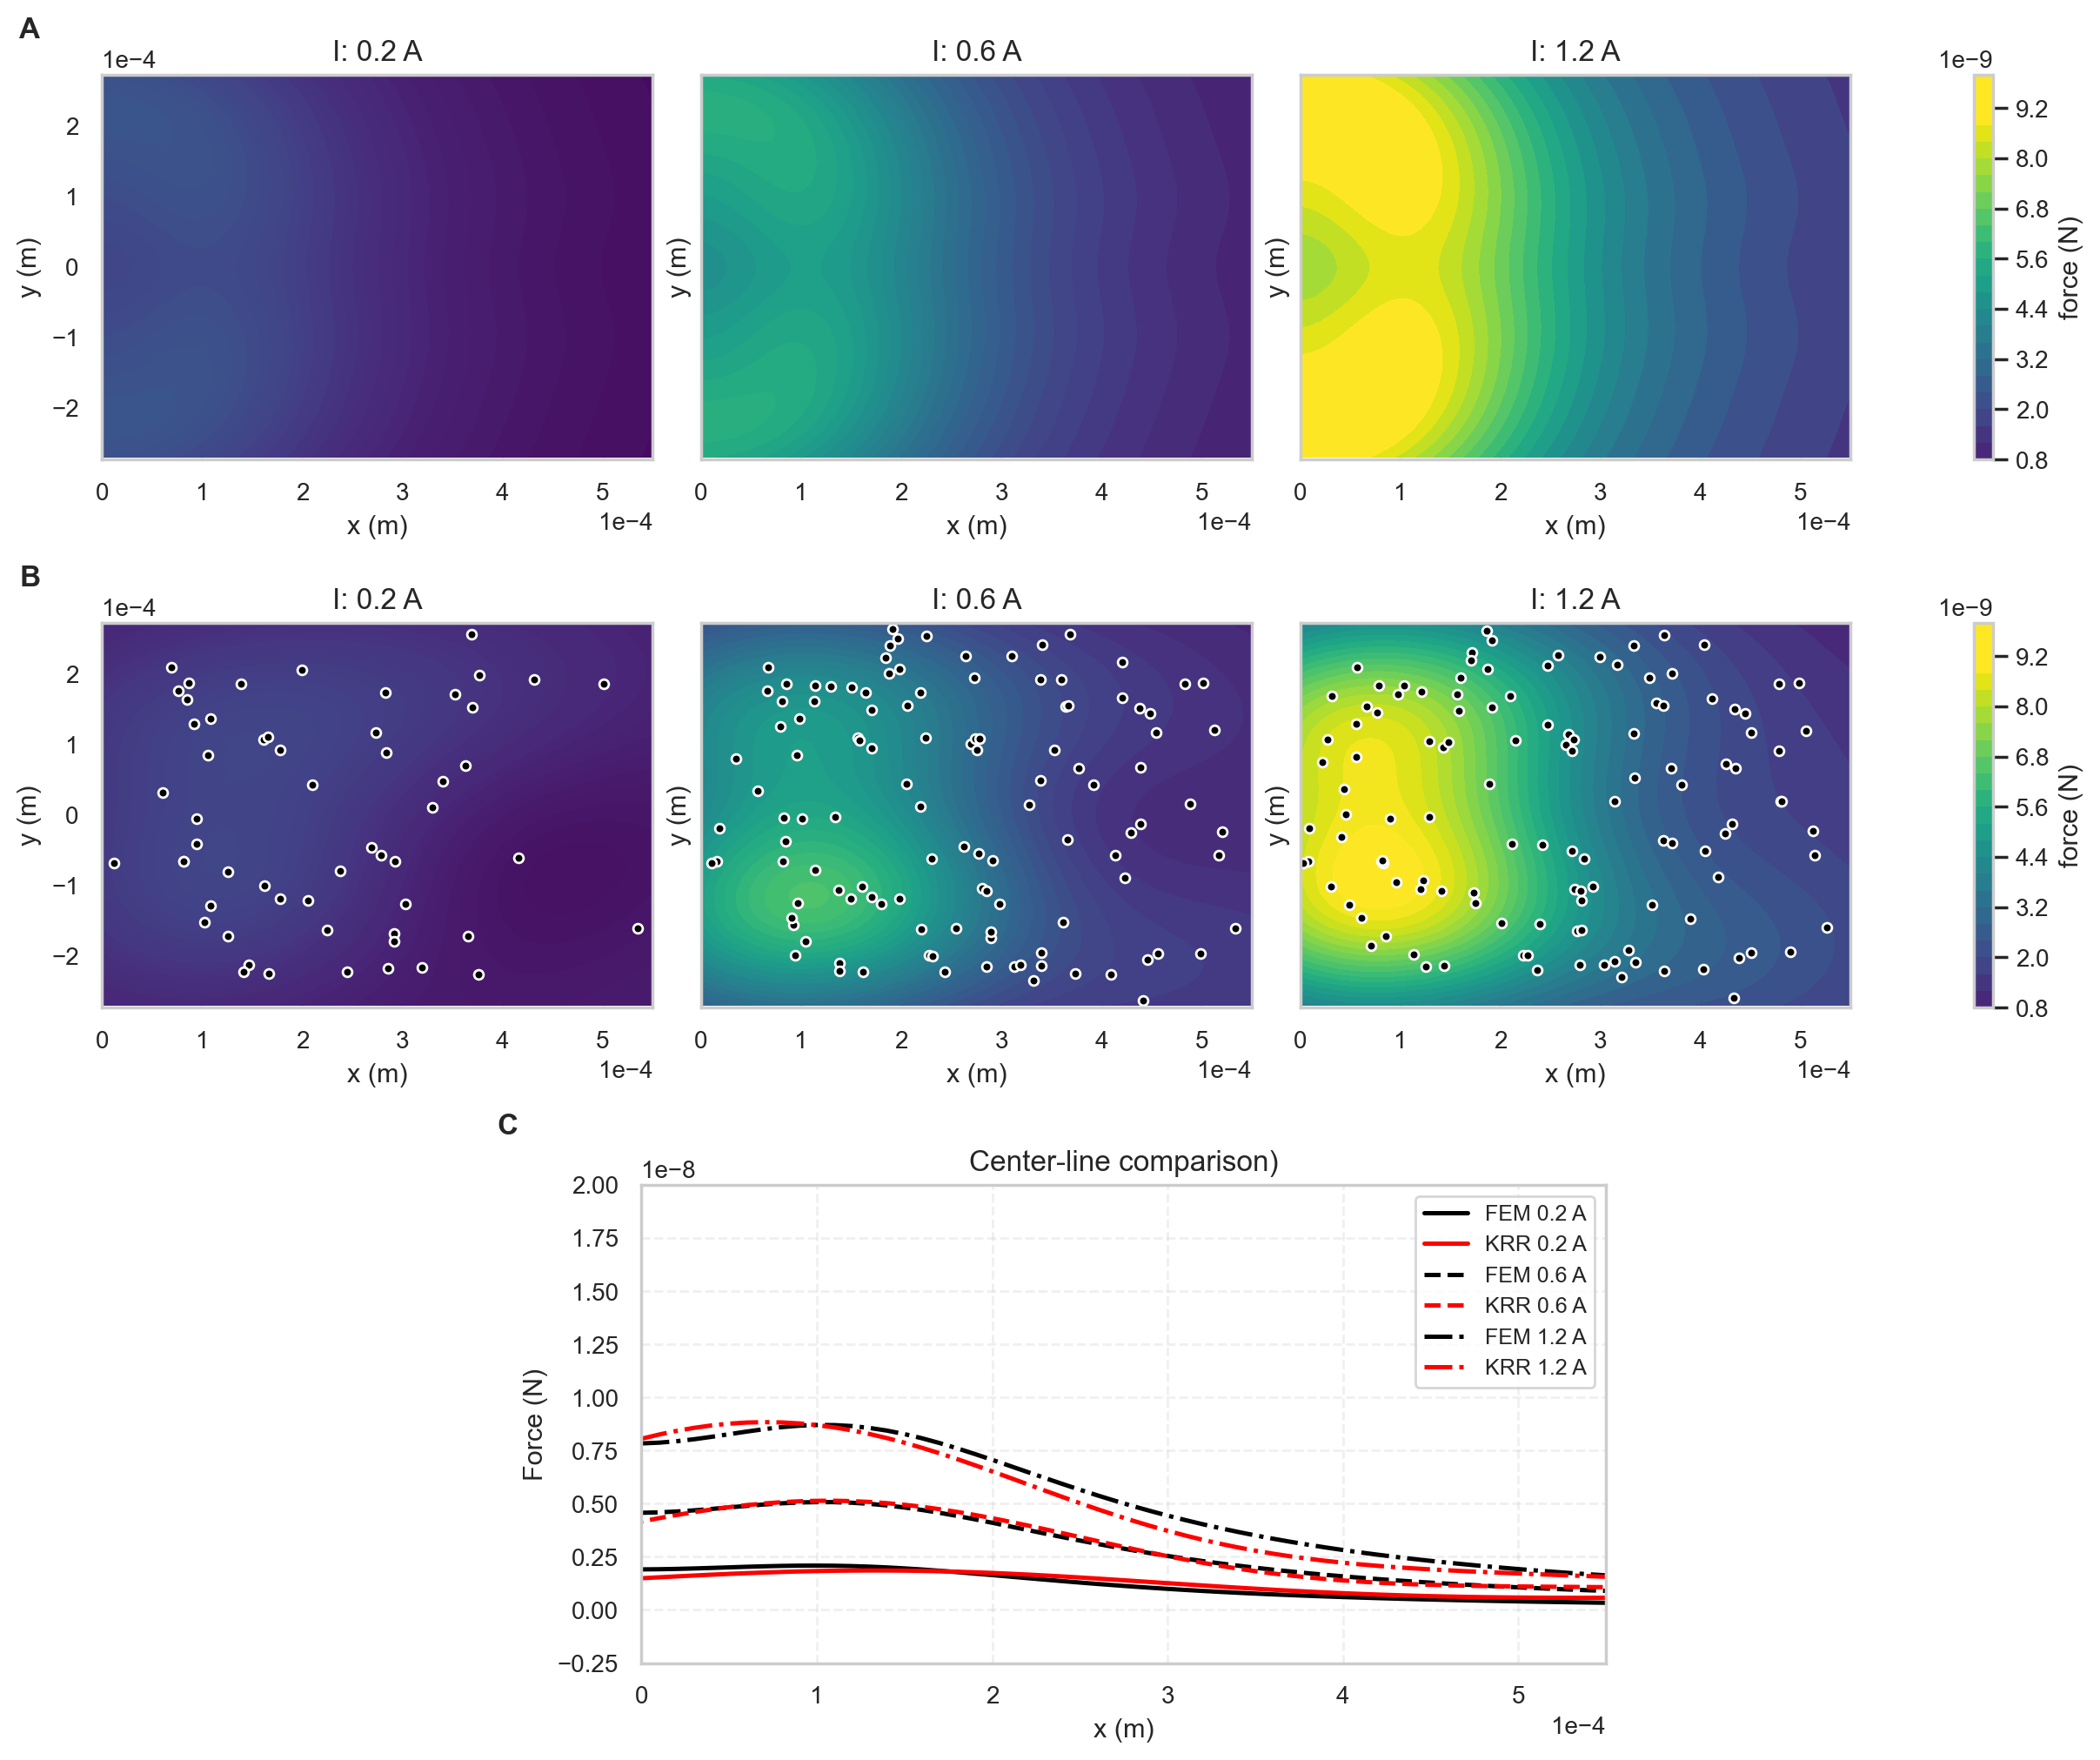

In [156]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(3, 1, height_ratios=[1.0, 1.0, 1.2], figure=fig)

subfig_top = fig.add_subfigure(gs[0])
subfig_middle = fig.add_subfigure(gs[1])
subfig_bottom = fig.add_subfigure(gs[2])

m = 3.5/(10*0.3*3.3)*1e-6
height_px  = 1544 #height of FoV in µm
width_px = 2064 #width of FoV in µm

height = 1544*m #height of FoV in µm
width = 2064*m #width of FoV in µm

axes = subfig_top.subplots(1, 3, sharey=True)
slice_ids = [2, len(ig)//2, len(ig)-1]

vmin = 0 #float(np.nanpercentile(krr_pred[:, :, level], 2))
vmax = float(np.nanpercentile(krr_diff[:, :, len(ig)-1], 98))



for ax, k in zip(axes, slice_ids):
    i_k = ig[k]
    cs = ax.contourf(x_axis, y_axis, force_control[:, :, k], levels=28, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(f"I: {np.round(i_k,1)} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")

    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, 5.5e-4])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

fig.colorbar(cs, ax=axes, label="force (N)")

add_panel_labels(axes, labels=["A"], xy=(-0.15, 1.15))  # top row

axes = subfig_middle.subplots(1, 3, sharey=True)
for ax, k in zip(axes, slice_ids):

    cs_ = ax.contourf(xg-1.5e-4, yg, krr_diff[:,:,k], levels=28, cmap="viridis", vmin=vmin, vmax=vmax)
    # overlay nearby measurements at this current
    i_k = ig[k]
    sl = mm_fit[np.isfinite(mm_fit["currents_level"]) & (np.abs(mm_fit["currents_level"]-i_k) <= 0.03*np.ptp(ig))]
 
    ax.scatter(sl["x_m"]-1.5e-4, sl["y_m"],color = "black", edgecolor="w", s=15) # c=sl["force"], cmap="viridis"
    ax.set_title(f"I: {np.round(ig[k],1)} A"); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")

    ax.set_ylim([-height/2, height/2])
    ax.set_xlim([0, 5.5e-4])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

fig.colorbar(cs, ax=axes, label="force (N)")

add_panel_labels(axes, labels=["B"], xy=(-0.15, 1.15))  # middle row

ax_dummy = subfig_bottom.add_gridspec(1, 3, width_ratios=[1, 2, 1])
axC = subfig_bottom.add_subplot(ax_dummy[0, 1])

center_row = 30
line_type = ["-", "--", "-."]
for level, lt in zip(slice_ids, line_type):
    axC.plot(x_axis, force_control[center_row, :, level], label=f"FEM {np.round(ig[level],1)} A", color="black", lw=1.8, linestyle=lt)
    axC.plot(xg  - 1.5e-4,  krr_diff[30,:,level], label=f"KRR {np.round(ig[level],1)} A", color="red", lw=1.8, linestyle=lt)

# # Shaded uncertainty band
# axC.fill_between(xg- 1e-4 , lower, upper, color='blue', alpha=0.20, label='GPR 5th–95th')
# # Mean difference line
# axC.plot(xg- 1e-4, gpr_diff[30,:,12], label="GPR", color="blue")

axC.set_xlabel("x (m)")
axC.set_ylabel("Force (N)")
axC.set_title(f"Center-line comparison)")
axC.legend(frameon=True, fontsize=9, loc="best")
axC.grid(alpha=0.3, linestyle='--')
axC.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axC.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axC.set_xlim([0, 5.5e-4])
axC.set_ylim([-0.25*1e-8, 2*1e-8])


add_panel_labels([axC], labels=["C"], xy=(-0.15, 1.15))          # bottom row

Relative average difference 0.16762393401693976
Relative average difference 0.06260122842409256
Relative average difference 0.1359489515274403


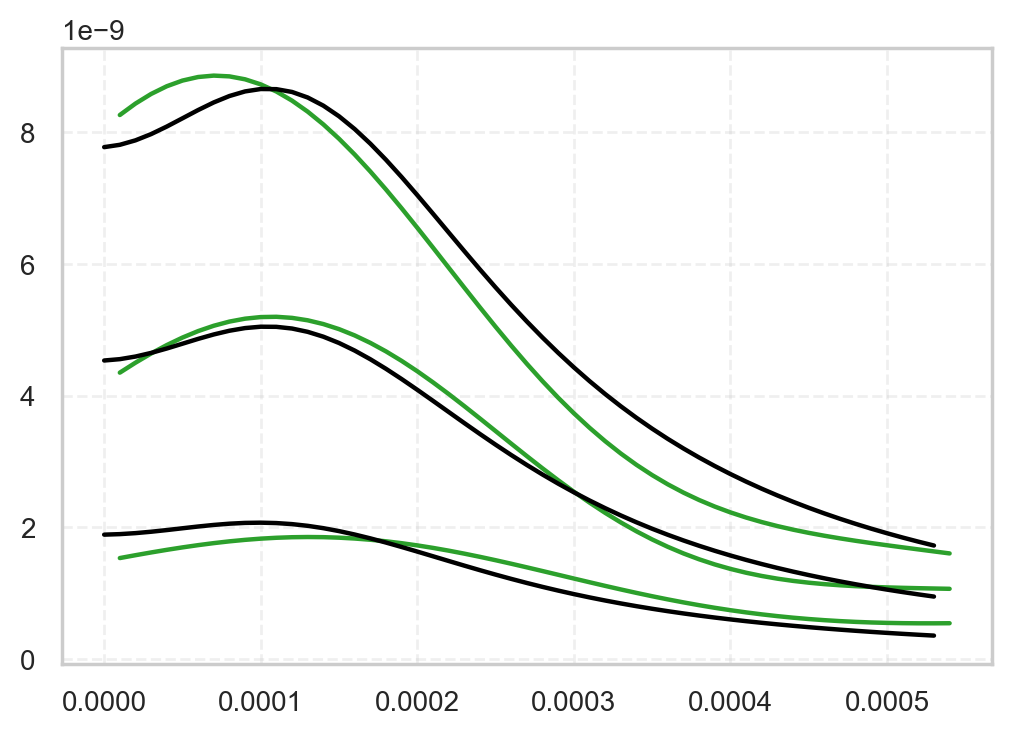

In [157]:
i_l = 12
y_l = 29

mask_krr = (xg > 1.5e-4) & (xg < 7e-4)
mask_fem = (xg < 5.4e-4)

for i_l in slice_ids:
    r_diff = np.abs((krr_diff[y_l, mask_krr, i_l] - force_control[y_l, mask_fem, i_l])/force_control[y_l, mask_fem, i_l])
    print("Relative average difference", np.mean(r_diff))

    plt.plot(x_axis[mask_krr]-1.5e-4, krr_diff[y_l, mask_krr, i_l], label="Saved model", color="tab:green", lw=1.6)
    plt.plot(x_axis[mask_fem], force_control[y_l, mask_fem, i_l], label="Saved model", color="black", lw=1.6)

ValueError: x and y must have same first dimension, but have shapes (73,) and (55, 73, 15)

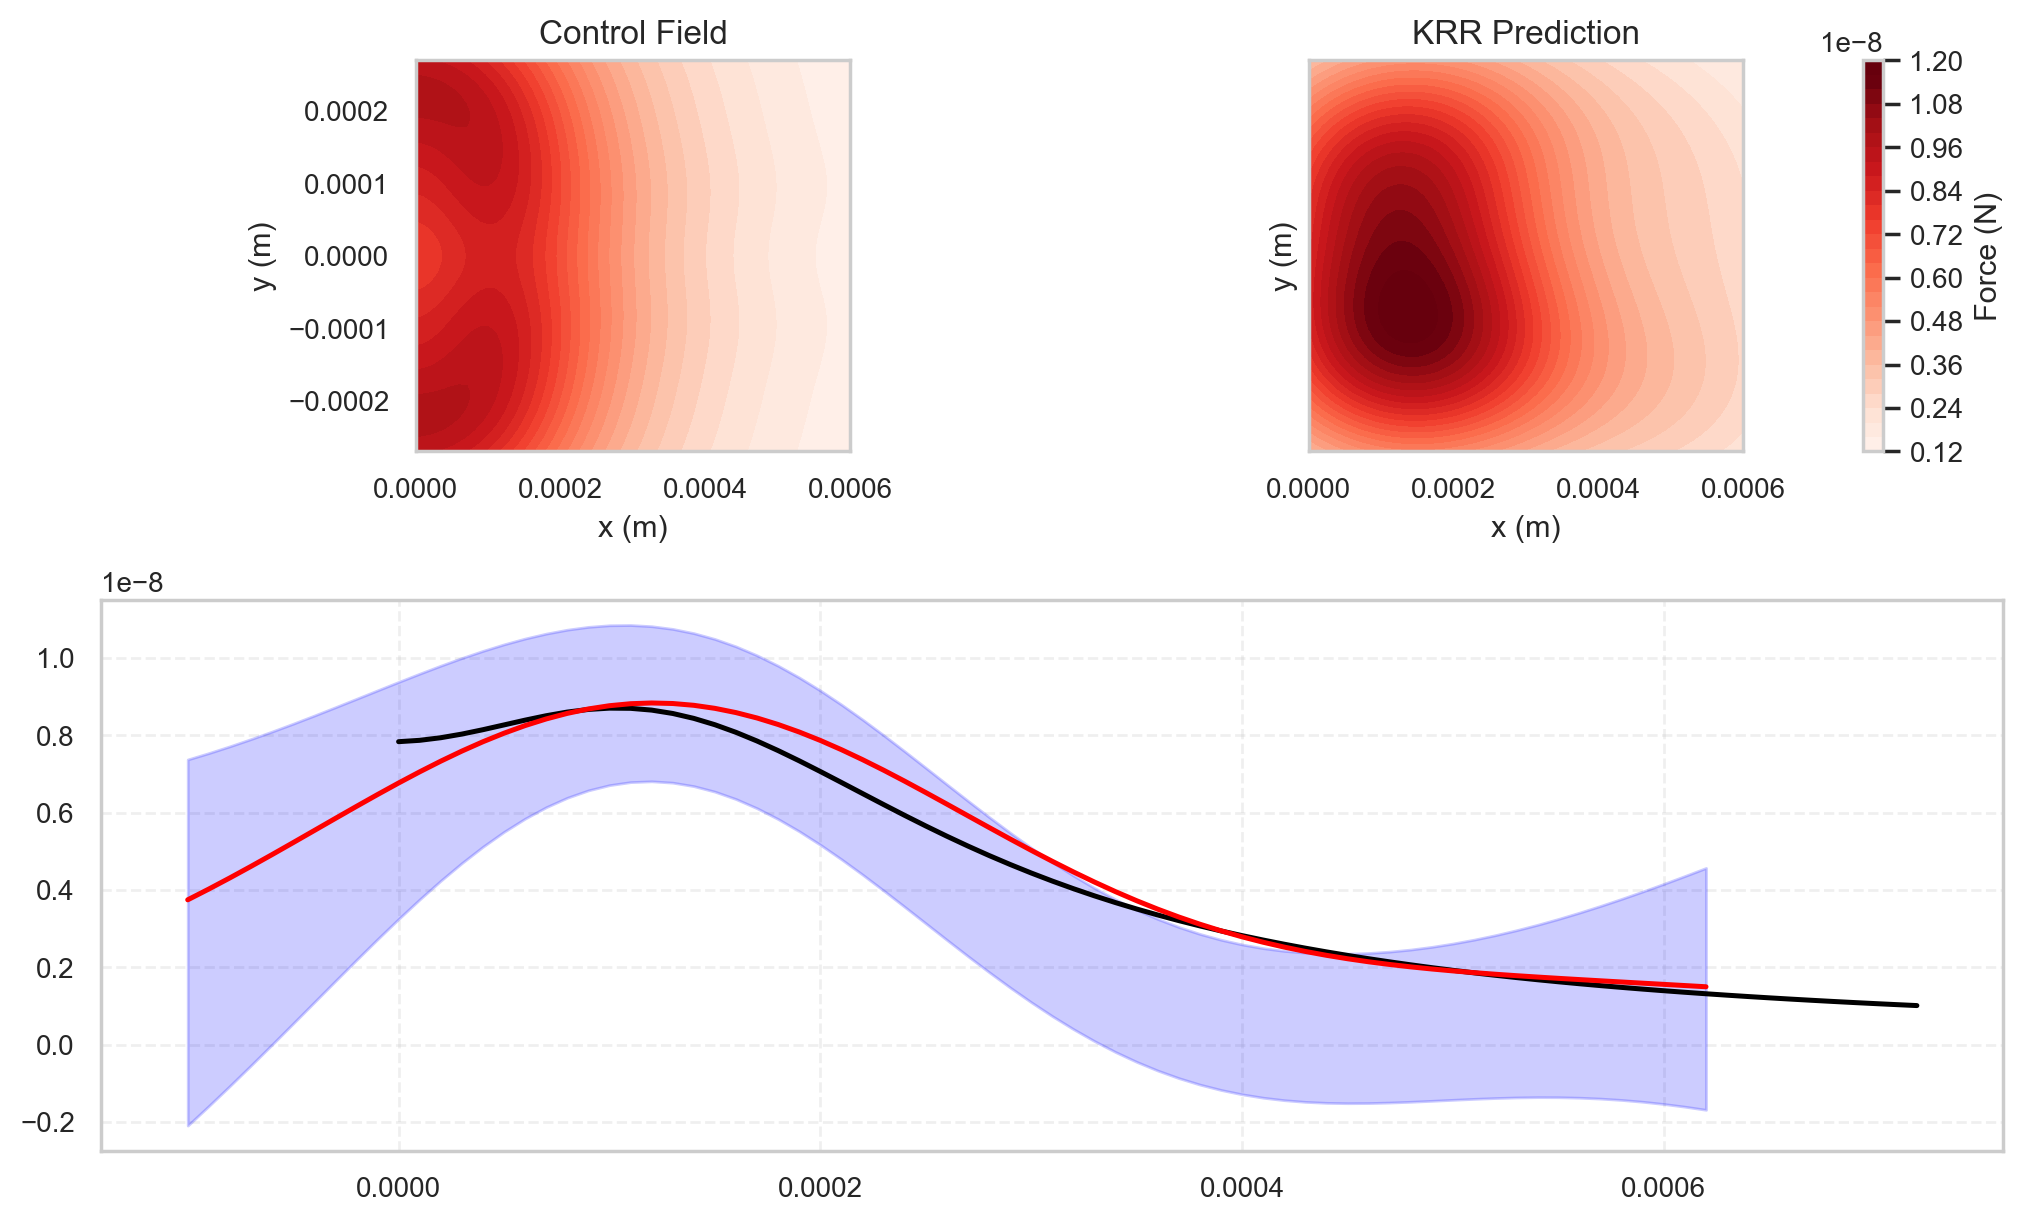

In [139]:
# Publication-ready layout with subfigures: A+B top row, C full-width bottom row
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
subfig_top, subfig_bottom = fig.subfigures(2, 1, height_ratios=[1.0, 1.2])

# Robust shared color scale across control and KRR for comparability
vmin_ctrl = float(np.nanpercentile(force_control[:, :, level], 2))
vmax_ctrl = float(np.nanpercentile(force_control[:, :, level], 98))
vmin_krr = float(np.nanpercentile(krr_pred[:, :, level], 2))
vmax_krr = float(np.nanpercentile(krr_pred[:, :, level], 98))

vmin = min(vmin_ctrl, vmin_krr)
vmax = max(vmax_ctrl, vmax_krr)

# Top subfigure: two heatmaps side-by-side (A: Control, B: KRR)
axs_top = subfig_top.subplots(1, 2, sharey=True)

# Panel A: Control field
CS0 = axs_top[0].contourf(x_axis, y_axis, force_control[:, :, level], levels=28, cmap="Reds", vmin=vmin, vmax=vmax)
axs_top[0].set_title("Control Field")
axs_top[0].set_xlabel("x (m)")
axs_top[0].set_ylabel("y (m)")
axs_top[0].set_aspect('equal', adjustable='box')
axs_top[0].set_xlim([x_axis.min(), 6e-4]) #x_axis.max()
axs_top[0].set_ylim([y_axis.min(), y_axis.max()]) #y_axis.max()

# Panel B: KRR prediction
CS1 = axs_top[1].contourf(xg-1e-4, yg, krr_pred[:, :, level], levels=28, cmap="Reds", vmin=vmin, vmax=vmax)
axs_top[1].set_title("KRR Prediction")
axs_top[1].set_xlabel("x (m)")
axs_top[1].set_ylabel("y (m)")
axs_top[1].set_aspect('equal', adjustable='box')
axs_top[1].set_xlim([0, 6e-4])
axs_top[1].set_ylim([yg.min(), y_axis.max()])

# Shared colorbar for A and B with the same scale
cbar_top = subfig_top.colorbar(CS1, ax=axs_top, pad=0.02)
cbar_top.ax.set_ylabel("Force (N)")

# Bottom subfigure: full-width center-line comparison (Panel C)
axC = subfig_bottom.subplots(1, 1)
center_row = 30
ctrl_line = force_control[center_row, :, level]
axC.plot(x_axis, ctrl_line, label="FEM simulation", color="black", lw=1.8)

# KRR difference slice — interpolate to control x-axis for alignment
krr_diff = krr_pred[center_row, :, level] - krr_pred_ref[center_row, :, level]
krr_diff_i = np.interp(x_axis, xg, krr_diff)
axC.plot(x_axis - 1e-4, krr_diff_i, label="KRR", color="red", lw=1.8)

# Shaded uncertainty band
axC.fill_between(xg - 1e-4, lower, upper, color='blue', alpha=0.20, label='GPR 5th–95th')
# Mean difference line
axC.plot(xg - 1e-4, gpr_diff, label="GPR", color="blue")

axC.set_xlabel("x (m)")
axC.set_ylabel("Force (N)")
axC.set_title(f"Center-line comparison (level = 1.2 A)")
axC.legend(frameon=True, fontsize=9, loc="best")
axC.grid(alpha=0.3, linestyle='--')
axC.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axC.set_xlim([0, 6.3e-4])
axC.set_ylim([-0.25*1e-8, 2*1e-8])

add_panel_labels(axs_top, labels=["A", "B"])  # top row
add_panel_labels([axC], labels=["C"])          # bottom row


plt.show()